Groundwater | Case Study

# Topic 4 : Model implementation

Dr. Xiang-Zhao Kong & Dr. Beatrice Marti & Louise Noël du Payrat

In [1]:
# Import libraries
# Import libraries
import sys
import os
import time
import pandas as pd
import geopandas as gpd
import pickle
from shapely.geometry import Polygon, Point
from shapely.affinity import rotate, translate
from shapely.ops import unary_union
from scipy.interpolate import griddata
from affine import Affine
from scipy.ndimage import binary_dilation, minimum_filter
import tempfile

import rasterio
from rasterio.warp import reproject, Resampling, transform_bounds
import rasterio.features
from rasterio.features import rasterize  # Add this import
from rasterio.transform import rowcol

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.colors as mcolors

import flopy
from flopy.discretization import StructuredGrid
from flopy.utils import Raster, GridIntersect

# Add the support repo to the path
sys.path.append('../SUPPORT_REPO/src')
sys.path.append('../SUPPORT_REPO/src/scripts/scripts_exercises')

# Import local modules
from data_utils import download_named_file, get_default_data_folder
from plot_utils import plot_cross_section

Starting search for project root from: /Users/bea/Documents/GitHub/applied_groundwater_modelling/CASE_STUDY
Checking path: /Users/bea/Documents/GitHub/applied_groundwater_modelling/CASE_STUDY
Marker file not found in /Users/bea/Documents/GitHub/applied_groundwater_modelling/CASE_STUDY. Moving up...
Checking path: /Users/bea/Documents/GitHub/applied_groundwater_modelling
Found project root: /Users/bea/Documents/GitHub/applied_groundwater_modelling (marker: config.py)
Loaded configuration from 'config.py'


## Iterating the Model Top
To make sure we update all the relevant parts of the model, we will first implement the model top and then the river stage.
We will then cross-check the model top with the river stage and the DEM.

We re-initialize the model. 

In [2]:
# --- 1. Model Setup and Workspace ---
# Define the name of our model and the workspace where files will be stored.
model_name = 'limmat_valley_model'
workspace = os.path.join(get_default_data_folder(), model_name)

# Create the workspace directory if it doesn't exist
os.makedirs(workspace, exist_ok=True)

# Define the path to the MODFLOW executable
# This path might be different on your system.
# We assume it's in a standard location accessible from the system's PATH.
executable = 'mf2005' 

# Create the MODFLOW model object
mf = flopy.modflow.Modflow(modelname=model_name, model_ws=workspace, exe_name=executable)

### Discretization: Reuse the Rotated Grid

In [3]:
# Load model grid from a file if it exists
grid_file_path = os.path.join(workspace, 'model_grid.pkl')
if os.path.exists(grid_file_path):
    with open(grid_file_path, 'rb') as f:
        modelgrid = pickle.load(f)
else:
    print(f"Model grid file not found at {grid_file_path}. Please run the grid setup in notebook 4_model_implementation.ipynb first.")

# Print the model grid information
print(f"Model grid loaded with {modelgrid.nrow} rows and {modelgrid.ncol} columns.")


Model grid loaded with 52 rows and 136 columns.


### Model Top
Now we adapt the model top. We use the high-resolution DEM from the Swiss Federal Office of Topography (swisstopo) as the model top. If you are interested in how to download the DEM and to merge the tiles, please refer to the `processing_DEM.ipynb` in `SUPPPORT_REPO/src/scripts/scripts_limmat_data_preprocessing/`.   

swissalti3d_merged_lv03.tif already exists in /Users/bea/applied_groundwater_modelling_data/limmat/gis.
swissalti3d_merged_lv03_readme.pdf already exists in /Users/bea/applied_groundwater_modelling_data/limmat/gis.
DEM CRS: EPSG:21781
Model grid CRS: EPSG:21781
CRS are compatible, no transformation needed
DEM elevation range: 387.3 to 722.2 meters


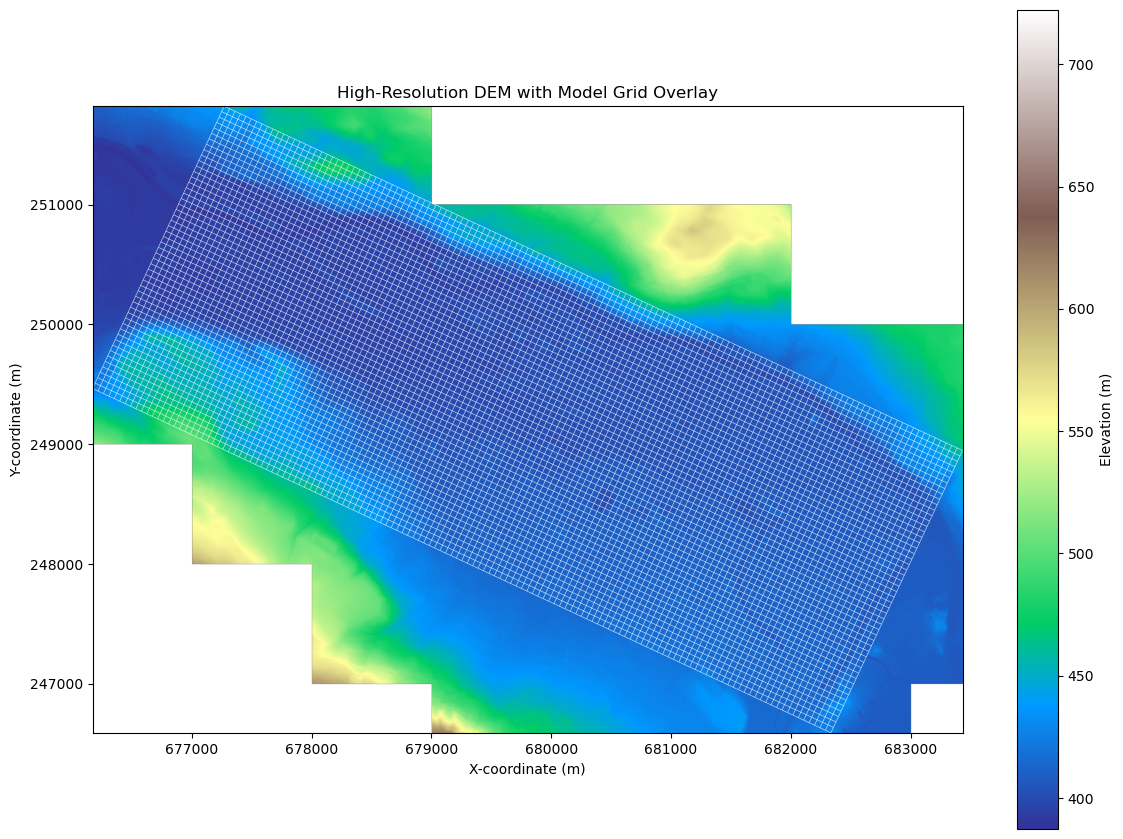

In [4]:
# Load the DEM data
dem_path = download_named_file(
    name='dem_hres',
    data_type='gis'
)

# Check CRS compatibility first
with rasterio.open(dem_path) as src:
    dem_crs = src.crs
    print(f"DEM CRS: {dem_crs}")
    print(f"Model grid CRS: {modelgrid.crs}")
    
    if str(dem_crs) != str(modelgrid.crs):
        print("CRS transformation needed")
        
        # Get the bounds of the model grid in its CRS
        grid_bounds = modelgrid.extent
        
        # Transform model grid bounds to DEM CRS for cropping
        dem_bounds = transform_bounds(
            modelgrid.crs, dem_crs, 
            grid_bounds[0], grid_bounds[2], 
            grid_bounds[1], grid_bounds[3]
        )
        
        # Read and crop the DEM data
        window = src.window(*dem_bounds)
        dem_data = src.read(1, window=window)
        dem_transform = src.window_transform(window)
        
        # Now reproject the cropped DEM to match the model grid CRS
        dst_crs = modelgrid.crs
        dst_transform, dst_width, dst_height = rasterio.warp.calculate_default_transform(
            dem_crs, dst_crs, dem_data.shape[1], dem_data.shape[0], *dem_bounds
        )
        
        # Create output array
        reprojected_dem = np.empty((dst_height, dst_width), dtype=dem_data.dtype)
        
        # Perform the reprojection
        reproject(
            dem_data,
            reprojected_dem,
            src_transform=dem_transform,
            src_crs=dem_crs,
            dst_transform=dst_transform,
            dst_crs=dst_crs,
            resampling=Resampling.bilinear
        )
        
        # Create a temporary raster file with the reprojected data
        import tempfile
        with tempfile.NamedTemporaryFile(suffix='.tif', delete=False) as tmp:
            tmp_path = tmp.name
            
        with rasterio.open(
            tmp_path, 'w',
            driver='GTiff',
            height=dst_height,
            width=dst_width,
            count=1,
            dtype=reprojected_dem.dtype,
            crs=dst_crs,
            transform=dst_transform,
        ) as dst:
            dst.write(reprojected_dem, 1)
        
        # Now load with FloPy Raster
        rio = Raster.load(tmp_path)
        
        # Clean up temporary file
        import os
        os.unlink(tmp_path)
        
    else:
        print("CRS are compatible, no transformation needed")
        rio = Raster.load(dem_path)

arr = rio.get_array(1)
# Mask values below 0 and set them to NaN
arr = np.where(arr <= 0, np.nan, arr)

idx = np.isfinite(arr)

vmin, vmax = arr[idx].min(), arr[idx].max()
print(f"DEM elevation range: {vmin:.1f} to {vmax:.1f} meters")

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, aspect="equal")

# Create a masked array for plotting to handle NaN values properly
masked_arr = np.ma.masked_invalid(arr)

# Plot the raster with proper extent
im = ax.imshow(masked_arr, extent=rio.bounds, vmin=vmin, vmax=vmax, cmap='terrain')
plt.colorbar(im, shrink=0.7, label="Elevation (m)")

# Plot the model grid on top
pmv = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax)
pmv.plot_grid(lw=0.5, color="white", alpha=0.7)

ax.set_title("High-Resolution DEM with Model Grid Overlay")
ax.set_xlabel("X-coordinate (m)")
ax.set_ylabel("Y-coordinate (m)")
plt.tight_layout()
plt.show()


Let's see if the DEM is consistent with the measurements of river stage. 

swissalti3d_merged_lv03.tif already exists in /Users/bea/applied_groundwater_modelling_data/limmat/gis.
swissalti3d_merged_lv03_readme.pdf already exists in /Users/bea/applied_groundwater_modelling_data/limmat/gis.
AV_Gewasser_-OGD.gpkg already exists in /Users/bea/applied_groundwater_modelling_data/limmat/gis.
AV_Gewasser_-OGD_readme.pdf already exists in /Users/bea/applied_groundwater_modelling_data/limmat/gis.
Wasserpegel_-OGD.gpkg already exists in /Users/bea/applied_groundwater_modelling_data/limmat/gis.
Wasserpegel_-OGD_readme.pdf already exists in /Users/bea/applied_groundwater_modelling_data/limmat/gis.


/var/folders/fx/fhbs7qgd6998fvtd5n8bs1lr0000gn/T/ipykernel_20606/1524167393.py:129: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  lines1, labels1 = ax.get_legend_handles_labels()
/var/folders/fx/fhbs7qgd6998fvtd5n8bs1lr0000gn/T/ipykernel_20606/1524167393.py:129: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  lines1, labels1 = ax.get_legend_handles_labels()


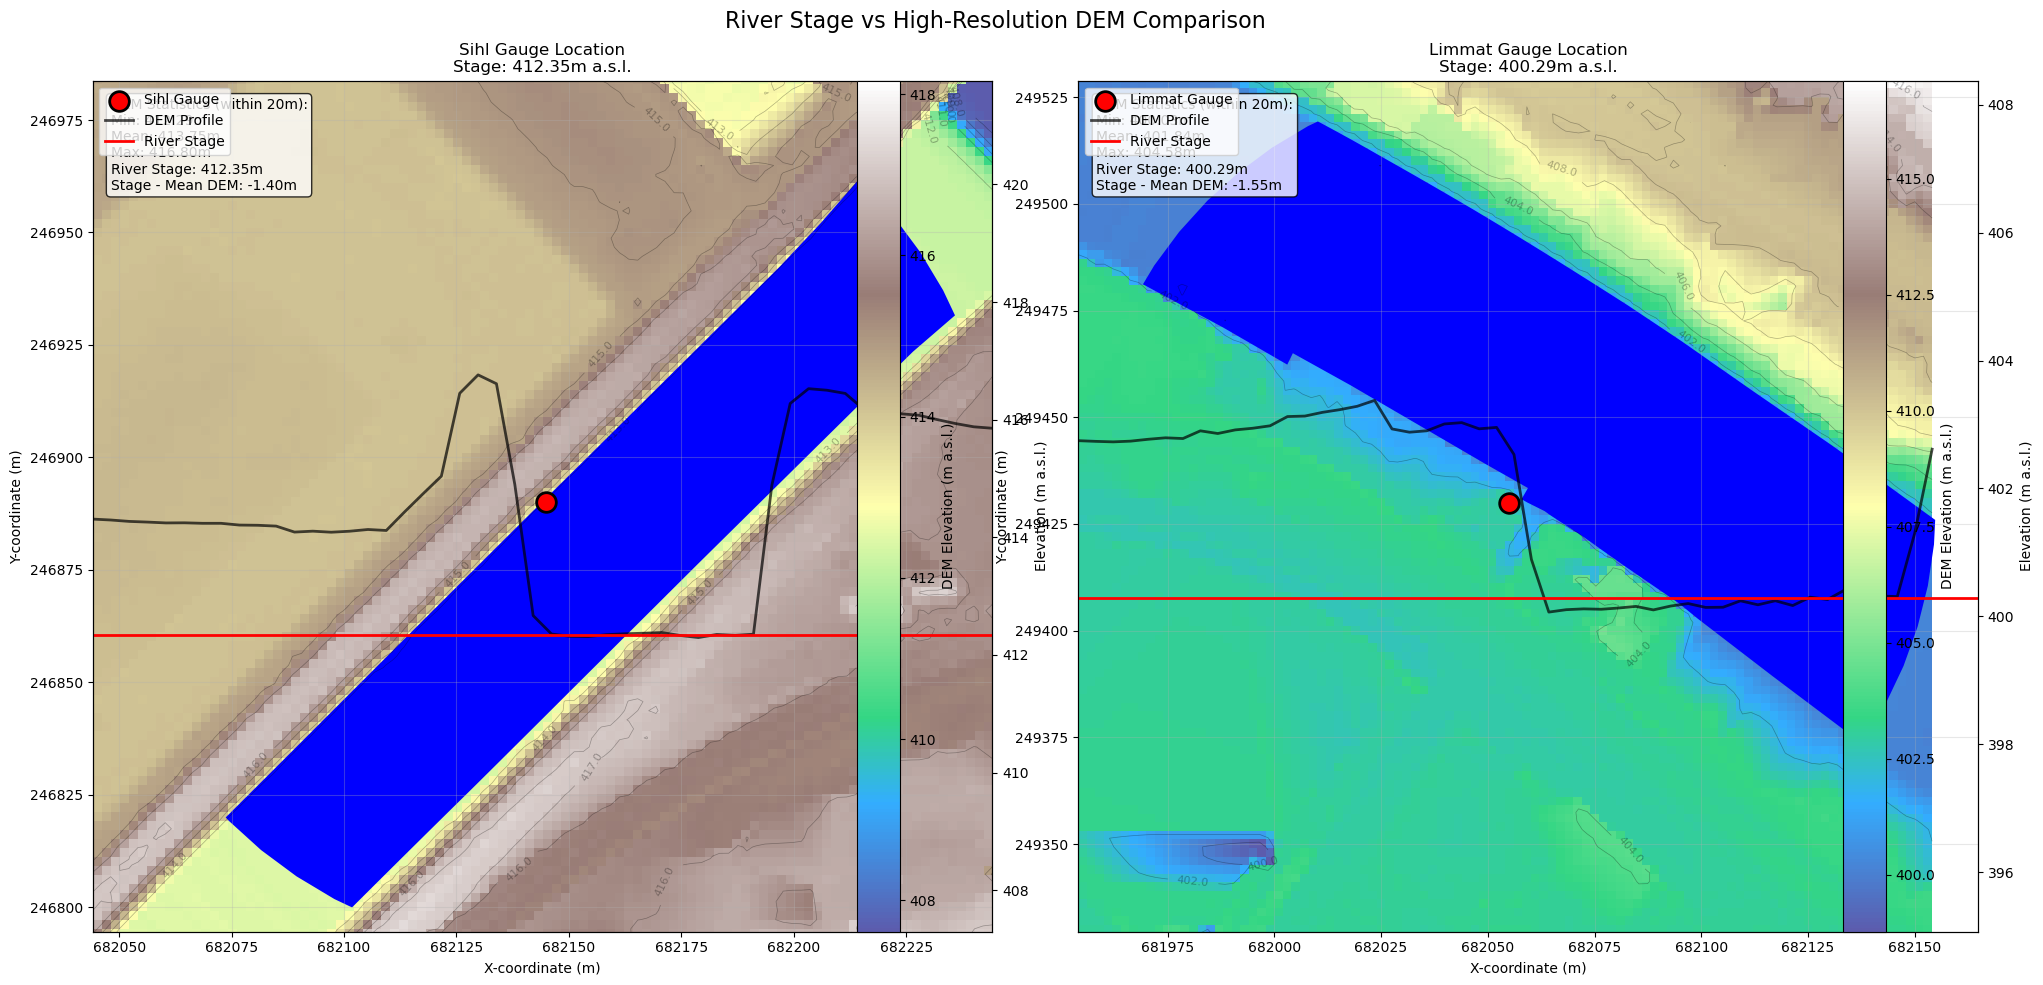

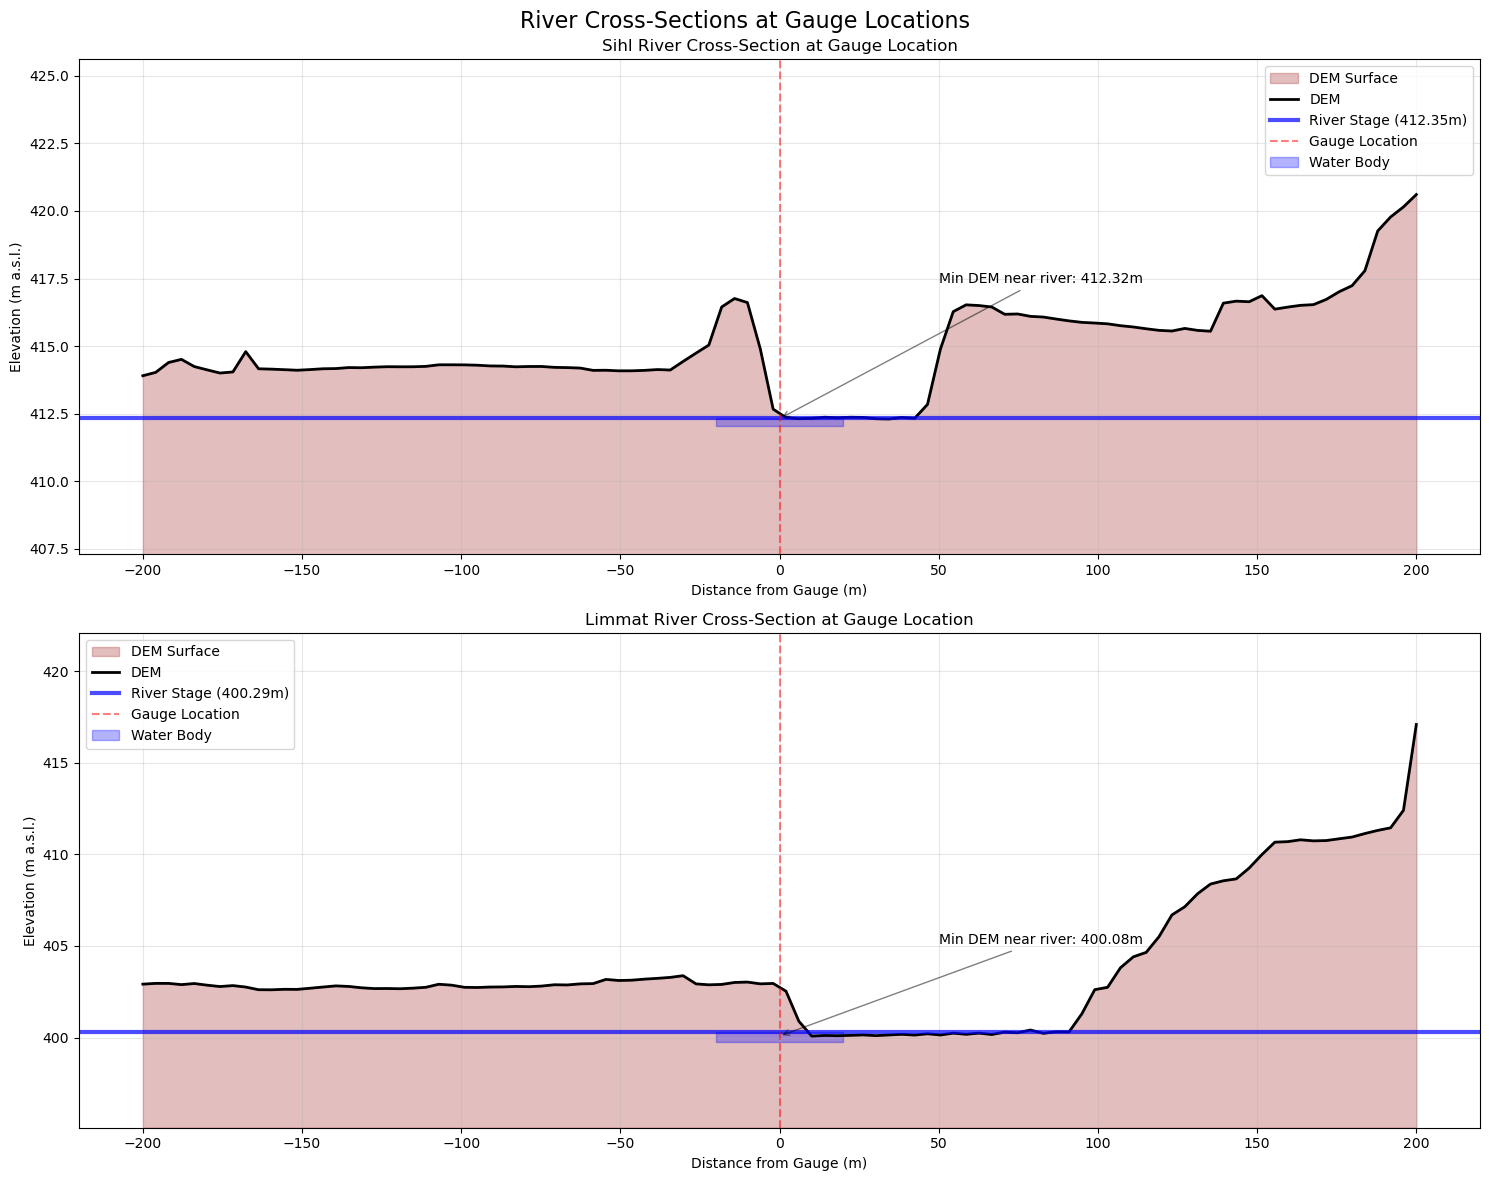


River Stage vs DEM Summary:
------------------------------------------------------------

Sihl Gauge:
  Location: (682145.0, 246890.0)
  River Stage: 412.35 m a.s.l.
  DEM Range: 412.29 - 416.80 m
  DEM Mean: 413.75 m
  Stage vs Mean DEM: -1.40 m

Limmat Gauge:
  Location: (682055.0, 249430.0)
  River Stage: 400.29 m a.s.l.
  DEM Range: 400.03 - 404.58 m
  DEM Mean: 401.84 m
  Stage vs Mean DEM: -1.55 m


In [5]:
# Load the high-resolution DEM (2m grid)
dem_path = download_named_file(name='dem_hres', data_type='gis')
dem_raster = Raster.load(dem_path)

# Load river shapes
rivers_path = download_named_file(name='rivers', data_type='gis')
rivers_gdf = gpd.read_file(rivers_path)
rivers_gdf = rivers_gdf.to_crs(dem_raster.crs)

# Load gauge locations
gauges_path = download_named_file(name='gauges', data_type='gis')
gauges_gdf = gpd.read_file(gauges_path, layer='GS_LIMNIGRAPHENSTATIONEN_P')
gauges_gdf = gauges_gdf.to_crs(dem_raster.crs)

# Known gauge stages (average values)
gauge_stages = {
    'Sihl': 412.347,    # m a.s.l.
    'Limmat': 400.285   # m a.s.l.
}

# Get DEM array and extent
dem_array = dem_raster.get_array(1)
dem_bounds = dem_raster.bounds
dem_transform = dem_raster.transform

# Create figure with subplots for each gauge
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Define buffer distance around gauges (in meters)
buffer_distance = 100  # 100m radius around gauge

for idx, (river_name, stage) in enumerate(gauge_stages.items()):
    ax = axes[idx]
    
    # Find gauge location
    river_gauges = gauges_gdf[gauges_gdf['NAME'].str.contains(river_name, case=False, na=False)]
    
    if len(river_gauges) > 0:
        gauge = river_gauges.iloc[0]
        gauge_x = gauge.geometry.x
        gauge_y = gauge.geometry.y
        
        # Create buffer around gauge
        gauge_buffer = gauge.geometry.buffer(buffer_distance)
        
        # Convert coordinates to pixel indices using the transform
        from rasterio.transform import rowcol
        
        # Get buffer bounds
        buffer_bounds = gauge_buffer.bounds
        
        # Convert bounds to row/col
        row_min, col_min = rowcol(dem_transform, buffer_bounds[0], buffer_bounds[3])
        row_max, col_max = rowcol(dem_transform, buffer_bounds[2], buffer_bounds[1])
        
        # Ensure indices are within bounds
        row_min = max(0, row_min)
        row_max = min(dem_array.shape[0], row_max)
        col_min = max(0, col_min)
        col_max = min(dem_array.shape[1], col_max)
        
        # Extract DEM subset
        dem_subset = dem_array[row_min:row_max, col_min:col_max]
        
        # Calculate extent for subset using transform
        from rasterio.transform import xy
        xmin, ymax = xy(dem_transform, row_min, col_min)
        xmax, ymin = xy(dem_transform, row_max, col_max)
        subset_extent = [xmin, xmax, ymin, ymax]
        
        # Plot DEM subset
        im = ax.imshow(dem_subset, extent=subset_extent, cmap='terrain', 
                       origin='upper', alpha=0.8)
        
        # Add contour lines
        X = np.linspace(subset_extent[0], subset_extent[1], dem_subset.shape[1])
        Y = np.linspace(subset_extent[3], subset_extent[2], dem_subset.shape[0])
        XX, YY = np.meshgrid(X, Y)
        contours = ax.contour(XX, YY, dem_subset, levels=10, colors='black', 
                             alpha=0.3, linewidths=0.5)
        ax.clabel(contours, inline=True, fontsize=8, fmt='%.1f')
        
        # Plot river sections within view
        rivers_clip = gpd.clip(rivers_gdf, gauge_buffer)
        if len(rivers_clip) > 0:
            rivers_clip.plot(ax=ax, color='blue', linewidth=3, label='River')
        
        # Plot gauge location
        ax.scatter(gauge_x, gauge_y, color='red', s=200, marker='o', 
                  edgecolor='black', linewidth=2, zorder=10, 
                  label=f'{river_name} Gauge')
        
        # Extract DEM values along a cross-section through the gauge
        # Create points along x-axis at gauge y-coordinate
        cross_x = np.linspace(subset_extent[0], subset_extent[1], 50)
        cross_y = np.full_like(cross_x, gauge_y)
        
        # Sample DEM at these points
        cross_dem = []
        for x, y in zip(cross_x, cross_y):
            row, col = rowcol(dem_transform, x, y)
            if 0 <= row < dem_array.shape[0] and 0 <= col < dem_array.shape[1]:
                cross_dem.append(dem_array[row, col])
            else:
                cross_dem.append(np.nan)
        
        # Set up twin axis for elevation profile
        ax_twin = ax.twinx()
        ax_twin.plot(cross_x, cross_dem, 'k-', linewidth=2, alpha=0.7, 
                    label='DEM Profile')
        ax_twin.axhline(y=stage, color='red', linewidth=2, 
                       label=f'River Stage')
        ax_twin.set_ylabel('Elevation (m a.s.l.)')
        ax_twin.set_ylim(min(np.nanmin(cross_dem) - 5, stage - 5), 
                        max(np.nanmax(cross_dem) + 5, stage + 5))
        
        # Colorbar for DEM
        cbar = plt.colorbar(im, ax=ax, pad=0.15)
        cbar.set_label('DEM Elevation (m a.s.l.)')
        
        # Labels and title
        ax.set_xlabel('X-coordinate (m)')
        ax.set_ylabel('Y-coordinate (m)')
        ax.set_title(f'{river_name} Gauge Location\nStage: {stage:.2f}m a.s.l.')
        ax.grid(True, alpha=0.3)
        ax.set_aspect('equal')
        
        # Add legend
        lines1, labels1 = ax.get_legend_handles_labels()
        lines2, labels2 = ax_twin.get_legend_handles_labels()
        ax.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
        
        # Add text box with statistics
        dem_near_gauge = []
        search_radius = 20  # meters
        search_pixels = int(search_radius / 2)  # 2m resolution
        
        # Get gauge pixel location
        gauge_row, gauge_col = rowcol(dem_transform, gauge_x, gauge_y)
        
        for dr in range(-search_pixels, search_pixels+1):
            for dc in range(-search_pixels, search_pixels+1):
                r, c = gauge_row + dr, gauge_col + dc
                if 0 <= r < dem_array.shape[0] and 0 <= c < dem_array.shape[1]:
                    dem_near_gauge.append(dem_array[r, c])
        
        if dem_near_gauge:
            stats_text = f"DEM Statistics (within {search_radius}m):\n"
            stats_text += f"Min: {np.min(dem_near_gauge):.2f}m\n"
            stats_text += f"Mean: {np.mean(dem_near_gauge):.2f}m\n"
            stats_text += f"Max: {np.max(dem_near_gauge):.2f}m\n"
            stats_text += f"River Stage: {stage:.2f}m\n"
            stats_text += f"Stage - Mean DEM: {stage - np.mean(dem_near_gauge):.2f}m"
            
            ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                   verticalalignment='top', fontsize=10)

plt.suptitle('River Stage vs High-Resolution DEM Comparison', fontsize=16)
plt.tight_layout()
plt.show()

# Create a detailed cross-section plot
fig2, axes2 = plt.subplots(2, 1, figsize=(15, 12))

for idx, (river_name, stage) in enumerate(gauge_stages.items()):
    ax = axes2[idx]
    
    # Find gauge location
    river_gauges = gauges_gdf[gauges_gdf['NAME'].str.contains(river_name, case=False, na=False)]
    
    if len(river_gauges) > 0:
        gauge = river_gauges.iloc[0]
        gauge_x = gauge.geometry.x
        gauge_y = gauge.geometry.y
        
        # Create cross-section perpendicular to river
        # First, find river direction near gauge
        gauge_buffer_small = gauge.geometry.buffer(50)
        rivers_near = gpd.clip(rivers_gdf, gauge_buffer_small)
        
        if len(rivers_near) > 0:
            # Sample points along cross-section
            cross_length = 200  # meters on each side
            n_points = 100
            
            # Create perpendicular cross-section
            # (simplified - assumes east-west cross-section)
            cross_x = np.linspace(gauge_x - cross_length, gauge_x + cross_length, n_points)
            cross_y = np.full_like(cross_x, gauge_y)
            
            # Sample DEM along cross-section
            cross_dem = []
            distances = []
            for x, y in zip(cross_x, cross_y):
                row, col = rowcol(dem_transform, x, y)
                if 0 <= row < dem_array.shape[0] and 0 <= col < dem_array.shape[1]:
                    cross_dem.append(dem_array[row, col])
                    distances.append(x - gauge_x)
                else:
                    cross_dem.append(np.nan)
                    distances.append(x - gauge_x)
            
            # Plot cross-section
            ax.fill_between(distances, np.nanmin(cross_dem) - 5, cross_dem, 
                           color='brown', alpha=0.3, label='DEM Surface')
            ax.plot(distances, cross_dem, 'k-', linewidth=2, label='DEM')
            
            # Plot water level
            ax.axhline(y=stage, color='blue', linewidth=3, alpha=0.7, 
                      label=f'River Stage ({stage:.2f}m)')
            
            # Mark gauge location
            ax.axvline(x=0, color='red', linestyle='--', alpha=0.5, 
                      label='Gauge Location')
            
            # Fill water area (approximate)
            water_bottom = stage - {'Sihl': 0.3, 'Limmat': 0.5}[river_name]
            ax.fill_between([-20, 20], water_bottom, stage, 
                           color='blue', alpha=0.3, label='Water Body')
            
            # Labels
            ax.set_xlabel('Distance from Gauge (m)')
            ax.set_ylabel('Elevation (m a.s.l.)')
            ax.set_title(f'{river_name} River Cross-Section at Gauge Location')
            ax.grid(True, alpha=0.3)
            ax.legend()
            
            # Set reasonable y-limits
            ax.set_ylim(np.nanmin(cross_dem) - 5, np.nanmax(cross_dem) + 5)
            
            # Add annotations
            min_dem_near_center = np.nanmin([d for d, dist in zip(cross_dem, distances) 
                                            if abs(dist) < 30])
            ax.annotate(f'Min DEM near river: {min_dem_near_center:.2f}m', 
                       xy=(0, min_dem_near_center), xytext=(50, min_dem_near_center + 5),
                       arrowprops=dict(arrowstyle='->', color='black', alpha=0.5))
            
            if stage < min_dem_near_center:
                ax.text(0.95, 0.95, 
                       f'WARNING: River stage ({stage:.2f}m) is below\nminimum DEM ({min_dem_near_center:.2f}m)',
                       transform=ax.transAxes, 
                       bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8),
                       verticalalignment='top', horizontalalignment='right',
                       fontsize=12)

plt.suptitle('River Cross-Sections at Gauge Locations', fontsize=16)
plt.tight_layout()
plt.show()

# Summary table
print("\nRiver Stage vs DEM Summary:")
print("-" * 60)
for river_name, stage in gauge_stages.items():
    river_gauges = gauges_gdf[gauges_gdf['NAME'].str.contains(river_name, case=False, na=False)]
    if len(river_gauges) > 0:
        gauge = river_gauges.iloc[0]
        gauge_x = gauge.geometry.x
        gauge_y = gauge.geometry.y
        
        # Get gauge pixel location
        gauge_row, gauge_col = rowcol(dem_transform, gauge_x, gauge_y)
        
        # Get DEM values near gauge
        dem_values = []
        search_pixels = 10  # 20m radius at 2m resolution
        for dr in range(-search_pixels, search_pixels+1):
            for dc in range(-search_pixels, search_pixels+1):
                r, c = gauge_row + dr, gauge_col + dc
                if 0 <= r < dem_array.shape[0] and 0 <= c < dem_array.shape[1]:
                    dem_values.append(dem_array[r, c])
        
        if dem_values:
            print(f"\n{river_name} Gauge:")
            print(f"  Location: ({gauge_x:.1f}, {gauge_y:.1f})")
            print(f"  River Stage: {stage:.2f} m a.s.l.")
            print(f"  DEM Range: {np.min(dem_values):.2f} - {np.max(dem_values):.2f} m")
            print(f"  DEM Mean: {np.mean(dem_values):.2f} m")
            print(f"  Stage vs Mean DEM: {stage - np.mean(dem_values):+.2f} m")

The elevations of the gauge stations are consistent with the DEM. 

Text(0, 0.5, 'Y-coordinate')

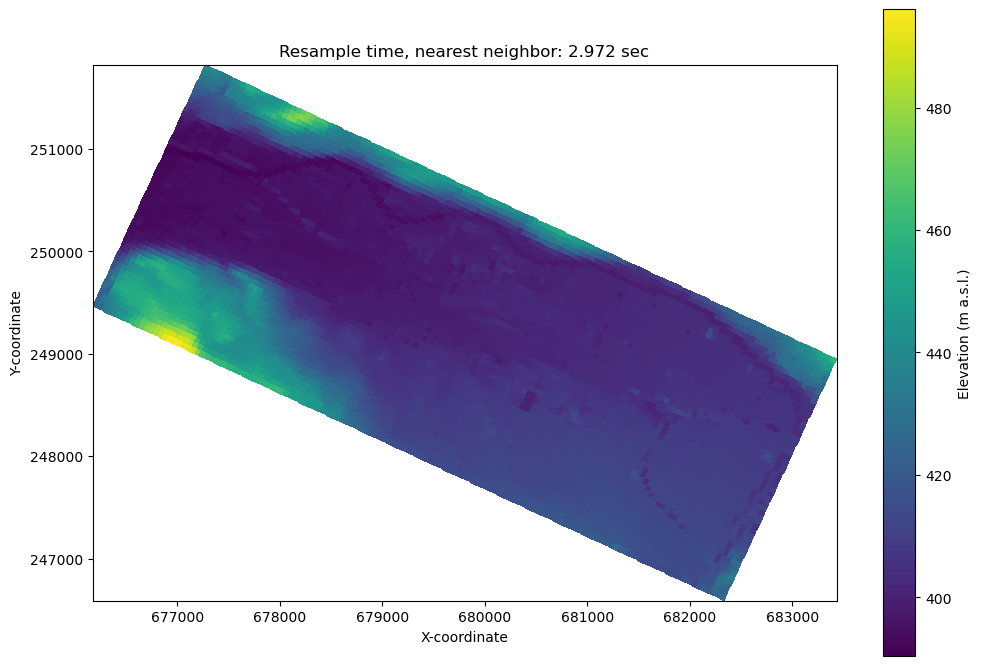

In [6]:
t0 = time.time()
model_top = rio.resample_to_grid(modelgrid, band=rio.bands[0], method="nearest")
resample_time = time.time() - t0

# We round to 10 centimeters to avoid having to store too many digits
model_top = np.round(model_top, 1)

# Update vmin and vmax based on the resampled data
vmin, vmax = model_top.min(), model_top.max()

# now to visualize using flopy and matplotlib
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, aspect="equal")

pmv = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax)
ax = pmv.plot_array(model_top, masked_values=rio.nodatavals, vmin=vmin, vmax=vmax)
plt.title(f"Resample time, nearest neighbor: {resample_time:.3f} sec")
plt.colorbar(ax, shrink=0.7, label="Elevation (m a.s.l.)")
plt.xlabel("X-coordinate")
plt.ylabel("Y-coordinate")

Burning river elevations into model grid...
AV_Gewasser_-OGD.gpkg already exists in /Users/bea/applied_groundwater_modelling_data/limmat/gis.
AV_Gewasser_-OGD_readme.pdf already exists in /Users/bea/applied_groundwater_modelling_data/limmat/gis.
limmat_model_boundary.gpkg already exists in /Users/bea/applied_groundwater_modelling_data/limmat/gis.
limmat_model_boundary_readme.md already exists in /Users/bea/applied_groundwater_modelling_data/limmat/gis.
swissalti3d_merged_lv03.tif already exists in /Users/bea/applied_groundwater_modelling_data/limmat/gis.
swissalti3d_merged_lv03_readme.pdf already exists in /Users/bea/applied_groundwater_modelling_data/limmat/gis.
Extracting minimum DEM elevations along river...
Wasserpegel_-OGD.gpkg already exists in /Users/bea/applied_groundwater_modelling_data/limmat/gis.
Wasserpegel_-OGD_readme.pdf already exists in /Users/bea/applied_groundwater_modelling_data/limmat/gis.
Creating continuous river profile...
Applying burned elevations to model grid

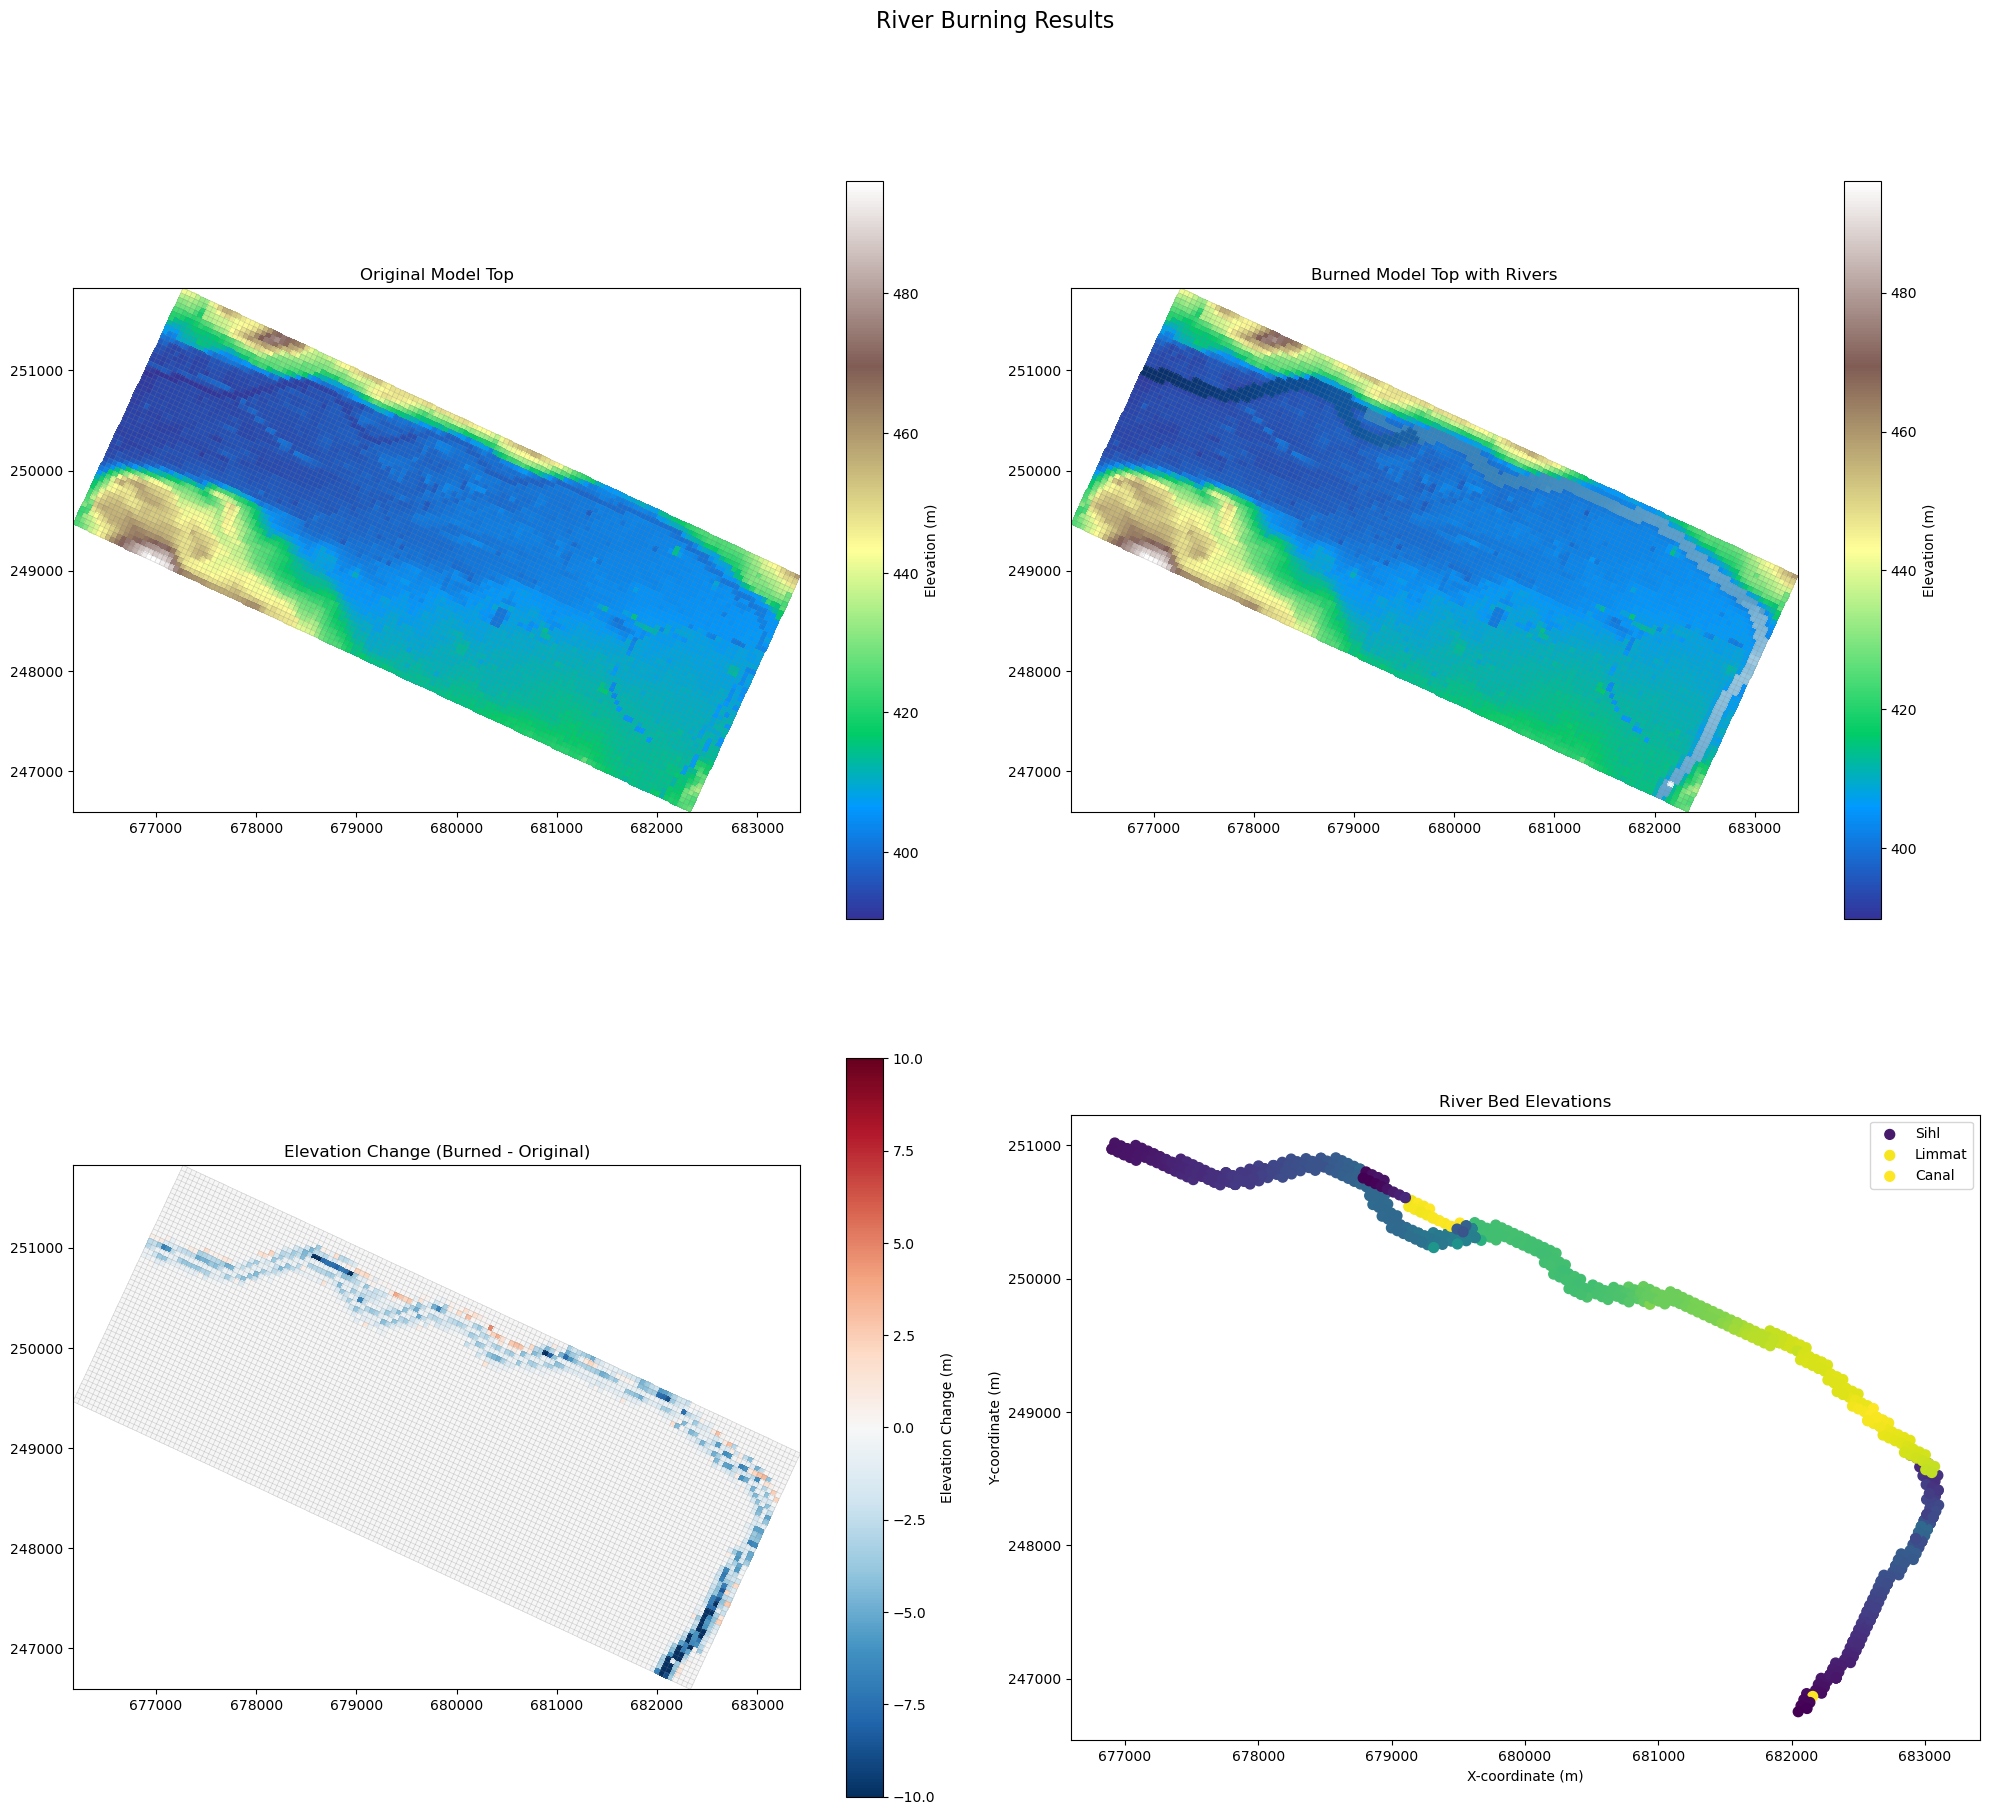


Updating model grid with burned river elevations...

River burning summary:
Number of river cells modified: 652
Average elevation change in river cells: -3.11 m
Maximum lowering: -17.00 m
River bed elevation range: 389.28 - 411.55 m


In [7]:
# --- River Elevation Burning into Model Grid ---
print("Burning river elevations into model grid...")

# First, recreate river cells if not already available
# Load river shapes
rivers_path = download_named_file(name='rivers', data_type='gis')
rivers_gdf = gpd.read_file(rivers_path)
rivers_gdf = rivers_gdf.to_crs(modelgrid.crs)

boundary_path = download_named_file(name='model_boundary', data_type='gis')

# Clip rivers to model boundary
boundary_gdf = gpd.read_file(boundary_path)
boundary_gdf = boundary_gdf.to_crs(modelgrid.crs)
river_clipped = gpd.clip(rivers_gdf, boundary_gdf)

# Filter for relevant rivers
river_clipped = river_clipped[
    (river_clipped['GEWAESSERNAME'].isin(['Sihl', 'Limmat'])) |
    (river_clipped['OBJID'].isin(['32998', '34996', '37804', '95527']))
]

# Group rivers
river_clipped['river_group'] = 'Canal'  # Default
river_clipped.loc[river_clipped['GEWAESSERNAME'] == 'Sihl', 'river_group'] = 'Sihl'
river_clipped.loc[river_clipped['GEWAESSERNAME'] == 'Limmat', 'river_group'] = 'Limmat'

# Create GridIntersect object
ix = GridIntersect(modelgrid, method='vertex')

# Get all river cells
river_cells_all = []
for idx, river_segment in river_clipped.iterrows():
    result = ix.intersect(river_segment.geometry)
    
    if len(result) > 0:
        result_df = pd.DataFrame(result)
        
        for i, cell in result_df.iterrows():
            # Get cell indices
            if 'row' in cell:
                row, col = cell['row'], cell['col']
            elif 'i' in cell:
                row, col = cell['i'], cell['j']
            else:
                if 'cellids' in cell:
                    row, col = cell['cellids'][0], cell['cellids'][1]
                else:
                    continue
            
            # Get length
            if 'length' in cell:
                length = cell['length']
            elif 'lengths' in cell:
                length = cell['lengths']
            else:
                length = 50.0  # default to cell size
            
            # Get cell center coordinates
            x_center = modelgrid.xcellcenters[int(row), int(col)]
            y_center = modelgrid.ycellcenters[int(row), int(col)]
            
            river_cells_all.append({
                'row': int(row),
                'col': int(col),
                'x': x_center,
                'y': y_center,
                'length': float(length),
                'river_group': river_segment['river_group']
            })

# Convert to DataFrame
river_cells_df = pd.DataFrame(river_cells_all)

# Load high-resolution DEM
dem_path = download_named_file(name='dem_hres', data_type='gis')
dem_raster = Raster.load(dem_path)
dem_array = dem_raster.get_array(1)
dem_transform = dem_raster.transform

# Extract minimum DEM elevation for each river cell from high-resolution DEM
print("Extracting minimum DEM elevations along river...")

# Get model grid cell size
cell_size = modelgrid.delr[0]
# Get number of rows and columns in the model grid
nrow_rotated, ncol_rotated = modelgrid.nrow, modelgrid.ncol

# Get minimum DEM values for each model grid river cell
river_cells_with_dem = []

for idx, cell in river_cells_df.iterrows():
    row = cell['row']
    col = cell['col']
    x_center = cell['x']
    y_center = cell['y']
    
    # Define search box in model cell (50m x 50m)
    half_size = cell_size / 2
    search_coords = []
    
    # Sample points within the model cell
    n_samples = 10  # 10x10 grid within each model cell
    for dx in np.linspace(-half_size, half_size, n_samples):
        for dy in np.linspace(-half_size, half_size, n_samples):
            search_coords.append((x_center + dx, y_center + dy))
    
    # Get DEM values at sample points
    dem_values = []
    for x, y in search_coords:
        dem_row, dem_col = rowcol(dem_transform, x, y)
        if 0 <= dem_row < dem_array.shape[0] and 0 <= dem_col < dem_array.shape[1]:
            # Get a small window around the point to find channel bottom
            r_min = max(0, dem_row - 2)
            r_max = min(dem_array.shape[0], dem_row + 3)
            c_min = max(0, dem_col - 2)
            c_max = min(dem_array.shape[1], dem_col + 3)
            
            window = dem_array[r_min:r_max, c_min:c_max]
            dem_values.append(np.min(window))  # Take minimum in window
    
    if dem_values:
        min_dem = np.min(dem_values)
        mean_dem = np.mean(dem_values)
    else:
        min_dem = model_top[row, col]
        mean_dem = model_top[row, col]
    
    river_cells_with_dem.append({
        'idx': idx,
        'row': row,
        'col': col,
        'x': x_center,
        'y': y_center,
        'river_group': cell['river_group'],
        'min_dem': min_dem,
        'mean_dem': mean_dem,
        'model_top': model_top[row, col]
    })

river_dem_df = pd.DataFrame(river_cells_with_dem)

# Load gauge locations
gauges_path = download_named_file(name='gauges', data_type='gis')
gauges_gdf = gpd.read_file(gauges_path, layer='GS_LIMNIGRAPHENSTATIONEN_P')
gauges_gdf = gauges_gdf.to_crs(modelgrid.crs)

# Known gauge stages
gauge_stages = {
    'Sihl': 412.347,    # m a.s.l.
    'Limmat': 400.285   # m a.s.l.
}

# Find gauge cells
gauge_cells = {}
for river_name in ['Sihl', 'Limmat']:
    river_gauges = gauges_gdf[gauges_gdf['NAME'].str.contains(river_name, case=False, na=False)]
    if len(river_gauges) > 0:
        gauge_x = river_gauges.iloc[0].geometry.x
        gauge_y = river_gauges.iloc[0].geometry.y
        
        # Find nearest river cell to gauge
        river_group_cells = river_cells_df[river_cells_df['river_group'] == river_name]
        if len(river_group_cells) > 0:
            distances = np.sqrt((river_group_cells['x'] - gauge_x)**2 + 
                              (river_group_cells['y'] - gauge_y)**2)
            nearest_idx = river_group_cells.iloc[distances.argmin()].name
            gauge_cells[river_name] = {
                'idx': nearest_idx,
                'row': river_cells_df.loc[nearest_idx, 'row'],
                'col': river_cells_df.loc[nearest_idx, 'col'],
                'stage': gauge_stages[river_name]
            }

# Find westernmost river cells (outflow boundary)
min_x = river_cells_df['x'].min()
western_threshold = min_x + 100  # Within 100m of western boundary

limmat_cells = river_cells_df[river_cells_df['river_group'] == 'Limmat']
western_limmat = limmat_cells[limmat_cells['x'] <= western_threshold]
if len(western_limmat) > 0:
    outflow_idx = western_limmat['x'].idxmin()
    outflow_cell = river_cells_df.loc[outflow_idx]

# Create simple interpolation along river
print("Creating continuous river profile...")

# Collect all river cells with their minimum DEM
all_bed_elevations = {}

# Define river parameters
river_params = {
    'Sihl': {'water_depth': 0.3, 'safety_margin': 0.5},
    'Limmat': {'water_depth': 0.5, 'safety_margin': 0.5},
    'Canal': {'water_depth': 5.0, 'safety_margin': 0.5}
}

# Simple approach: assign elevations based on position and constraints
for idx, cell in river_dem_df.iterrows():
    min_dem = cell['min_dem']
    river_group = cell['river_group']
    
    # Get appropriate water depth and safety margin
    params = river_params.get(river_group, river_params['Canal'])
    
    # Calculate base elevation
    if river_group == 'Sihl' and 'Sihl' in gauge_cells and idx == gauge_cells['Sihl']['idx']:
        # At Sihl gauge
        bed_elev = gauge_stages['Sihl'] - params['water_depth'] - params['safety_margin']
    elif river_group == 'Limmat' and 'Limmat' in gauge_cells and idx == gauge_cells['Limmat']['idx']:
        # At Limmat gauge
        bed_elev = gauge_stages['Limmat'] - params['water_depth'] - params['safety_margin']
    elif 'outflow_idx' in locals() and idx == outflow_idx:
        # At outflow
        bed_elev = min_dem - 1.0
    else:
        # Interpolate based on position
        # Simple gradient from upstream to downstream
        y_position = cell['y']
        
        # Assume general north-to-south flow
        # Higher y = upstream, lower y = downstream
        y_max = river_dem_df['y'].max()
        y_min = river_dem_df['y'].min()
        
        # Normalize position (0 = downstream, 1 = upstream)
        if y_max > y_min:
            normalized_pos = (y_position - y_min) / (y_max - y_min)
        else:
            normalized_pos = 0.5
        
        # Interpolate between typical upstream and downstream elevations
        if river_group == 'Sihl':
            upstream_elev = 412.0
            downstream_elev = 400.0
        elif river_group == 'Limmat':
            upstream_elev = 405.0
            downstream_elev = 395.0
        else:  # Canal
            upstream_elev = 402.0
            downstream_elev = 395.0
        
        bed_elev = downstream_elev + (upstream_elev - downstream_elev) * normalized_pos
    
    # Ensure bed is below DEM
    bed_elev = min(bed_elev, min_dem - 0.5)
    
    all_bed_elevations[idx] = bed_elev

# Create new model_top array with burned river elevations
model_top_burned = model_top.copy()

# Burn river bed elevations into model top
print("Applying burned elevations to model grid...")

for idx, bed_elev in all_bed_elevations.items():
    if idx in river_dem_df.index:
        cell = river_dem_df.loc[idx]
        row, col = int(cell['row']), int(cell['col'])
        
        # For river cells, set the model top to the river bed elevation
        model_top_burned[row, col] = bed_elev

# Smooth transitions between river and non-river cells
# Create mask for river cells
river_mask = np.zeros_like(model_top_burned, dtype=bool)
for idx, cell in river_dem_df.iterrows():
    river_mask[int(cell['row']), int(cell['col'])] = True

# Apply gentle smoothing to transition zones
from scipy.ndimage import binary_dilation

transition_zone = 2  # cells
for i in range(transition_zone):
    # Dilate river mask
    extended_mask = binary_dilation(river_mask, iterations=i+1)
    transition_mask = extended_mask & ~river_mask
    
    # Blend elevations in transition zone
    weight = 1.0 - (i + 1) / (transition_zone + 1)
    for row in range(nrow_rotated):
        for col in range(ncol_rotated):
            if transition_mask[row, col]:
                neighbors = []
                for dr, dc in [(-1,0), (1,0), (0,-1), (0,1)]:
                    nr, nc = row + dr, col + dc
                    if 0 <= nr < nrow_rotated and 0 <= nc < ncol_rotated:
                        neighbors.append(model_top_burned[nr, nc])
                if neighbors:
                    blended = weight * model_top_burned[row, col] + (1-weight) * np.mean(neighbors)
                    model_top_burned[row, col] = blended

# Visualization of results
fig, axes = plt.subplots(2, 2, figsize=(20, 20))

# Plot 1: Original model top
ax1 = axes[0, 0]
pmv1 = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax1)
im1 = pmv1.plot_array(model_top, cmap='terrain')
pmv1.plot_grid(alpha=0.3, linewidth=0.5)
plt.colorbar(im1, ax=ax1, shrink=0.7, label='Elevation (m)')
ax1.set_title('Original Model Top')
ax1.set_aspect('equal')

# Plot 2: Burned model top with rivers
ax2 = axes[0, 1]
pmv2 = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax2)
im2 = pmv2.plot_array(model_top_burned, cmap='terrain')
pmv2.plot_grid(alpha=0.3, linewidth=0.5)

# Highlight river cells
river_array = np.full((nrow_rotated, ncol_rotated), np.nan)
for idx, cell in river_dem_df.iterrows():
    row, col = int(cell['row']), int(cell['col'])
    river_array[row, col] = all_bed_elevations[idx]

pmv2.plot_array(np.ma.masked_invalid(river_array), alpha=0.8, cmap='Blues_r')
plt.colorbar(im2, ax=ax2, shrink=0.7, label='Elevation (m)')
ax2.set_title('Burned Model Top with Rivers')
ax2.set_aspect('equal')

# Plot 3: Difference map
ax3 = axes[1, 0]
pmv3 = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax3)
diff = model_top_burned - model_top
im3 = pmv3.plot_array(diff, cmap='RdBu_r', vmin=-10, vmax=10)
pmv3.plot_grid(alpha=0.3, linewidth=0.5)
plt.colorbar(im3, ax=ax3, shrink=0.7, label='Elevation Change (m)')
ax3.set_title('Elevation Change (Burned - Original)')
ax3.set_aspect('equal')

# Plot 4: River elevations by group
ax4 = axes[1, 1]
for river_group in ['Sihl', 'Limmat', 'Canal']:
    group_data = river_dem_df[river_dem_df['river_group'] == river_group]
    if len(group_data) > 0:
        elevs = [all_bed_elevations[idx] for idx in group_data.index]
        ax4.scatter(group_data['x'], group_data['y'], c=elevs, 
                   label=river_group, s=50, cmap='viridis')

ax4.set_xlabel('X-coordinate (m)')
ax4.set_ylabel('Y-coordinate (m)')
ax4.set_title('River Bed Elevations')
ax4.legend()
ax4.set_aspect('equal')

plt.suptitle('River Burning Results', fontsize=16)
plt.tight_layout()
plt.show()

# Update the model grid with burned elevations
print("\nUpdating model grid with burned river elevations...")
model_top = model_top_burned.copy()

# Get model grid dimensions
nlay = modelgrid.nlay
delr = modelgrid.delr
delc = modelgrid.delc
model_bottom = modelgrid.botm.copy()
# Get the origin of the model grid, the lower left corner
xll_rotated = modelgrid.xoffset
yll_rotated = modelgrid.yoffset
grid_rotation_angle = modelgrid.angrot
crs = modelgrid.crs

# Update the modelgrid
modelgrid = StructuredGrid(
    delr=delr,
    delc=delc,
    top=model_top,
    botm=model_bottom,
    nlay=nlay,
    nrow=nrow_rotated,
    ncol=ncol_rotated,
    xoff=xll_rotated,
    yoff=yll_rotated,
    angrot=grid_rotation_angle,
    lenuni=2,
    crs=crs
)

# Update in MODFLOW model
mf.modelgrid = modelgrid

# Print summary statistics
print("\nRiver burning summary:")
print(f"Number of river cells modified: {len(all_bed_elevations)}")
print(f"Average elevation change in river cells: {np.mean([diff[int(c['row']), int(c['col'])] for _, c in river_dem_df.iterrows()]):.2f} m")
print(f"Maximum lowering: {np.min(diff):.2f} m")
print(f"River bed elevation range: {min(all_bed_elevations.values()):.2f} - {max(all_bed_elevations.values()):.2f} m")

Let's draw a length profile of the river bottom and compare it with the DEM. 

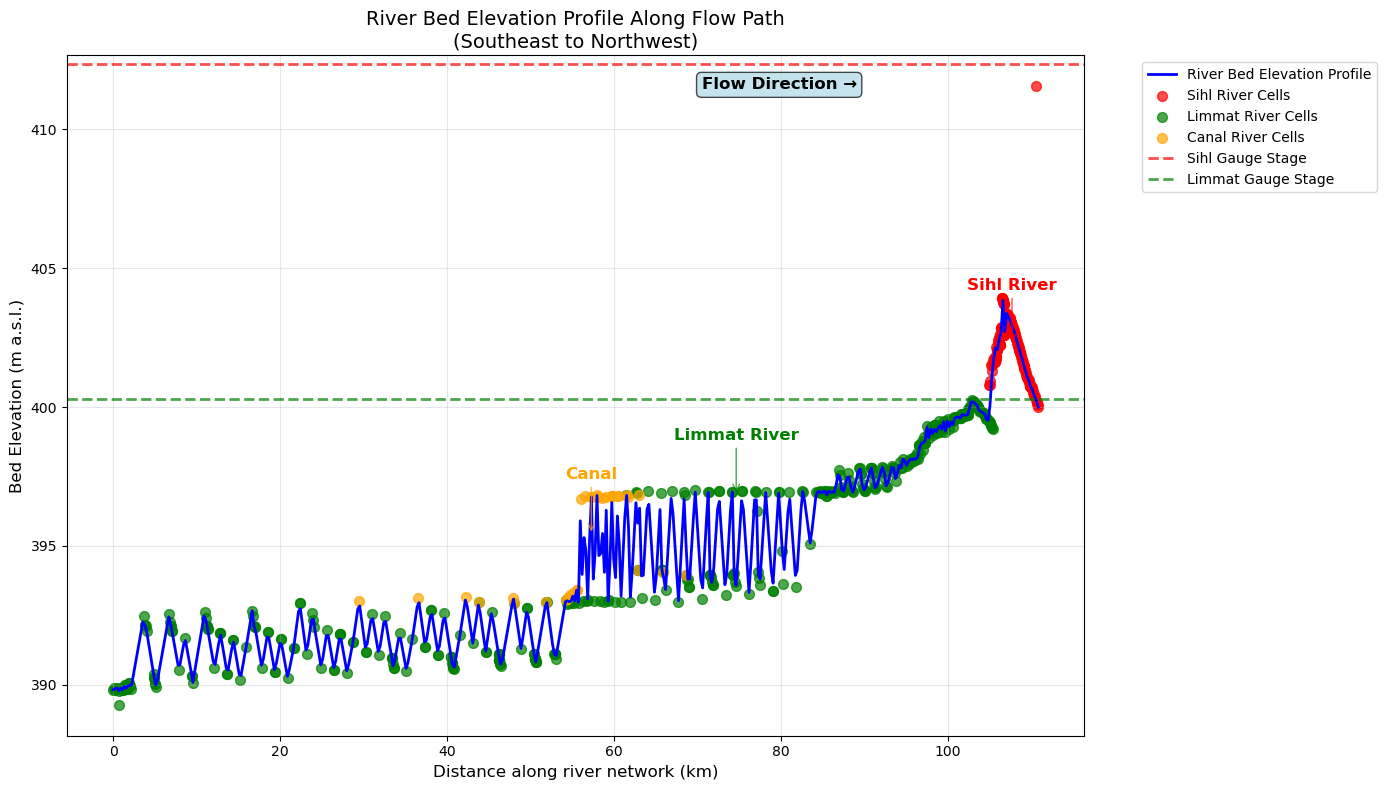


River Profile Statistics:
Total network length: 110.78 km
Elevation range: 389.3 - 411.5 m a.s.l.
Average gradient: 0.201 m/km

Sihl:
  Length: 5.85 km
  Elevation range: 400.0 - 411.5 m
  Number of cells: 149

Limmat:
  Length: 105.34 km
  Elevation range: 389.3 - 400.3 m
  Number of cells: 471

Canal:
  Length: 39.20 km
  Elevation range: 393.0 - 396.8 m
  Number of cells: 32


In [8]:
# Extract the river bed elevations along the length of the river and plot it 
import matplotlib.pyplot as plt
# Create a DataFrame for river bed elevations
river_bed_df = pd.DataFrame({
    'x': river_dem_df['x'],
    'y': river_dem_df['y'],
    'bed_elevation': [all_bed_elevations[idx] for idx in river_dem_df.index],
    'river_group': river_dem_df['river_group']
})      

# Extract the river bed elevations along the length of the river and plot it 
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Create a DataFrame for river bed elevations
river_bed_df = pd.DataFrame({
    'x': river_dem_df['x'],
    'y': river_dem_df['y'],
    'bed_elevation': [all_bed_elevations[idx] for idx in river_dem_df.index],
    'river_group': river_dem_df['river_group']
})      

# Calculate cumulative distance along the river network
# First, sort by position to create a reasonable flow path (southeast to northwest)
river_bed_df = river_bed_df.sort_values(by=['y', 'x'], ascending=[False, True])

# Calculate cumulative distance between consecutive points
distances = [0]  # Start at distance 0
for i in range(1, len(river_bed_df)):
    curr_x = river_bed_df.iloc[i]['x']
    curr_y = river_bed_df.iloc[i]['y']
    prev_x = river_bed_df.iloc[i-1]['x']
    prev_y = river_bed_df.iloc[i-1]['y']
    
    # Calculate distance between consecutive points
    point_distance = np.sqrt((curr_x - prev_x)**2 + (curr_y - prev_y)**2)
    distances.append(distances[-1] + point_distance)

river_bed_df['cumulative_distance'] = distances

# Convert distance to kilometers for better readability
river_bed_df['distance_km'] = river_bed_df['cumulative_distance'] / 1000

# Create a smooth interpolation for the profile
distance_values = river_bed_df['distance_km'].values
bed_elevations = river_bed_df['bed_elevation'].values

# Only interpolate if we have enough points
if len(distance_values) > 1:
    interp_func = interp1d(distance_values, bed_elevations, 
                          bounds_error=False, fill_value='extrapolate')
    # Create a smooth line for the profile
    distance_smooth = np.linspace(distance_values.min(), distance_values.max(), 500)
    elevation_smooth = interp_func(distance_smooth)
else:
    distance_smooth = distance_values
    elevation_smooth = bed_elevations

# Plot the river bed profile along distance
plt.figure(figsize=(14, 8))

# Plot smooth interpolated line
plt.plot(distance_smooth, elevation_smooth, label='River Bed Elevation Profile', 
         color='blue', linewidth=2)

# Plot individual points colored by river group
colors = {'Sihl': 'red', 'Limmat': 'green', 'Canal': 'orange'}
for river_group, color in colors.items():
    group_data = river_bed_df[river_bed_df['river_group'] == river_group]
    if len(group_data) > 0:
        plt.scatter(group_data['distance_km'], group_data['bed_elevation'], 
                   c=color, label=f'{river_group} River Cells', alpha=0.7, s=50)

# Add horizontal lines for gauge stages
plt.axhline(y=gauge_stages['Sihl'], color='red', linestyle='--', 
            label='Sihl Gauge Stage', alpha=0.7, linewidth=2)
plt.axhline(y=gauge_stages['Limmat'], color='green', linestyle='--', 
            label='Limmat Gauge Stage', alpha=0.7, linewidth=2)

# Add labels for different river sections
# Find approximate positions for labels
sihl_data = river_bed_df[river_bed_df['river_group'] == 'Sihl']
limmat_data = river_bed_df[river_bed_df['river_group'] == 'Limmat']
canal_data = river_bed_df[river_bed_df['river_group'] == 'Canal']

if len(sihl_data) > 0:
    sihl_mid_dist = sihl_data['distance_km'].median()
    sihl_mid_elev = sihl_data['bed_elevation'].median()
    plt.annotate('Sihl River', xy=(sihl_mid_dist, sihl_mid_elev), 
                xytext=(sihl_mid_dist, sihl_mid_elev + 2),
                fontsize=12, fontweight='bold', color='red',
                arrowprops=dict(arrowstyle='->', color='red', alpha=0.7),
                ha='center')

if len(limmat_data) > 0:
    limmat_mid_dist = limmat_data['distance_km'].median()
    limmat_mid_elev = limmat_data['bed_elevation'].median()
    plt.annotate('Limmat River', xy=(limmat_mid_dist, limmat_mid_elev), 
                xytext=(limmat_mid_dist, limmat_mid_elev + 2),
                fontsize=12, fontweight='bold', color='green',
                arrowprops=dict(arrowstyle='->', color='green', alpha=0.7),
                ha='center')

if len(canal_data) > 0:
    canal_mid_dist = canal_data['distance_km'].median()
    canal_mid_elev = canal_data['bed_elevation'].median()
    plt.annotate('Canal', xy=(canal_mid_dist, canal_mid_elev), 
                xytext=(canal_mid_dist, canal_mid_elev + 2),
                fontsize=12, fontweight='bold', color='orange',
                arrowprops=dict(arrowstyle='->', color='orange', alpha=0.7),
                ha='center')

plt.title('River Bed Elevation Profile Along Flow Path\n(Southeast to Northwest)', fontsize=14)
plt.xlabel('Distance along river network (km)', fontsize=12)
plt.ylabel('Bed Elevation (m a.s.l.)', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Add flow direction arrow
plt.annotate('Flow Direction →', xy=(0.7, 0.95), xycoords='axes fraction',
            fontsize=12, fontweight='bold', ha='center',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='lightblue', alpha=0.7))

plt.show()

# Print some statistics about the river profile
print(f"\nRiver Profile Statistics:")
print(f"Total network length: {river_bed_df['distance_km'].max():.2f} km")
print(f"Elevation range: {river_bed_df['bed_elevation'].min():.1f} - {river_bed_df['bed_elevation'].max():.1f} m a.s.l.")
print(f"Average gradient: {(river_bed_df['bed_elevation'].max() - river_bed_df['bed_elevation'].min()) / river_bed_df['distance_km'].max():.3f} m/km")

for river_group in ['Sihl', 'Limmat', 'Canal']:
    group_data = river_bed_df[river_bed_df['river_group'] == river_group]
    if len(group_data) > 0:
        print(f"\n{river_group}:")
        print(f"  Length: {group_data['distance_km'].max() - group_data['distance_km'].min():.2f} km")
        print(f"  Elevation range: {group_data['bed_elevation'].min():.1f} - {group_data['bed_elevation'].max():.1f} m")
        print(f"  Number of cells: {len(group_data)}")

In [9]:
# Load the aquifer thickness data
aquifer_thickness_file_path = os.path.join(workspace, 'aquifer_thickness.npy')
aquifer_thickness = np.load(aquifer_thickness_file_path)

# Calculate aquifer bottom elevation 
aquifer_bottom = model_top - aquifer_thickness

# Update the model grid with aquifer bottom
# Update the modelgrid
modelgrid = StructuredGrid(
    delr=delr,
    delc=delc,
    top=model_top,
    botm=model_bottom,
    nlay=nlay,
    nrow=nrow_rotated,
    ncol=ncol_rotated,
    xoff=xll_rotated,
    yoff=yll_rotated,
    angrot=grid_rotation_angle,
    lenuni=2,
    crs=crs
)

In [ ]:
ibound_path = os.path.join(workspace, 'ibound.npy')
ibound = np.load(ibound_path)

plot_cross_section(
    modelgrid=modelgrid,
    row=10,
    mf=mf, 
    ibound=ibound
)

After resampling, we do no longer see the grid cells representing the rivers. What is commonly done is to burn the river bottom into the DEM. 

TODO: Implement this

In [ ]:
# Load the outlines of the rivers in the model area
rivers = gpd.read_file(os.path.join(workspace, 'clipped_rivers.gpkg'), layer='clipped_rivers')

print("Extracting river elevations from high-resolution DEM and burning into model_top...")

# Define river burn parameters
river_burn_params = {
    'Sihl': {'burn_depth': 2.0, 'width': 30},      # Burn 2m below DEM
    'Limmat': {'burn_depth': 2.5, 'width': 40},    # Burn 2.5m below DEM  
    'Canal': {'burn_depth': 5.0, 'width': 10}      # Burn 5.0m below DEM 
}

# Create a copy of the original model_top for comparison
model_top_original = model_top.copy()

# Create GridIntersect object for river-grid intersection
ix = GridIntersect(modelgrid, method='vertex', rtree=True)

# Track burned cells for analysis
burned_cells_info = []

# Create coordinate arrays for sampling from high-res DEM
def sample_dem_at_points(points, dem_array, dem_transform):
    """Sample DEM values at given points using the DEM transform"""
    from rasterio.transform import rowcol
    
    elevations = []
    for x, y in points:
        try:
            # Convert world coordinates to pixel coordinates
            row, col = rowcol(dem_transform, x, y)
            
            # Check if coordinates are within DEM bounds
            if 0 <= row < dem_array.shape[0] and 0 <= col < dem_array.shape[1]:
                elevation = dem_array[row, col]
                if not np.isnan(elevation):
                    elevations.append(elevation)
            
        except Exception:
            continue
    
    return elevations

# Get the high-resolution DEM array and transform
with rasterio.open(dem_path) as src:
    # Read the DEM data in original CRS
    if str(src.crs) != str(modelgrid.crs):
        # Need to work with transformed DEM
        hires_dem_array = arr  # Use the already processed array from earlier
        # Create a transform for the high-res data
        # This is approximate - for exact results, we'd need the exact transform
        minx, miny, maxx, maxy = rio.bounds
        hires_transform = rasterio.transform.from_bounds(
            minx, miny, maxx, maxy, 
            hires_dem_array.shape[1], hires_dem_array.shape[0]
        )
    else:
        hires_dem_array = src.read(1)
        hires_transform = src.transform

print(f"High-res DEM shape: {hires_dem_array.shape}")
print(f"High-res DEM resolution: ~{abs(hires_transform[0]):.1f}m")

# Process each river segment
for idx, river_segment in rivers.iterrows():
    # Determine river type
    river_name = river_segment.get('GEWAESSERNAME', 'Canal')
    if pd.isna(river_name) or river_name not in ['Sihl', 'Limmat']:
        river_type = 'Canal'
    else:
        river_type = river_name
    
    # Get burn parameters
    burn_depth = river_burn_params[river_type]['burn_depth']
    river_width = river_burn_params[river_type]['width']
    
    # Get intersection with model grid
    try:
        result = ix.intersect(river_segment.geometry)
        
        if len(result) > 0:
            # Convert to DataFrame for easier handling
            result_df = pd.DataFrame(result)
            
            # Process each intersected cell
            for _, cell in result_df.iterrows():
                # Get cell indices
                if 'row' in cell:
                    row, col = int(cell['row']), int(cell['col'])
                elif 'i' in cell:
                    row, col = int(cell['i']), int(cell['j'])
                else:
                    continue
                
                # Check if cell is within grid bounds
                if 0 <= row < modelgrid.nrow and 0 <= col < modelgrid.ncol:
                    # Get cell center coordinates
                    cell_x = modelgrid.xcellcenters[row, col]
                    cell_y = modelgrid.ycellcenters[row, col]
                    
                    # Sample multiple points around the cell center along the river
                    # to get a representative river elevation
                    sample_points = []
                    
                    # Add cell center
                    sample_points.append((cell_x, cell_y))
                    
                    # Add points along the river segment within this cell
                    try:
                        # Get the part of the river segment that intersects this cell
                        cell_bounds = [
                            modelgrid.xvertices[row, col], modelgrid.yvertices[row, col],
                            modelgrid.xvertices[row, col+1], modelgrid.yvertices[row+1, col+1]
                        ]
                        cell_polygon = Polygon([
                            (cell_bounds[0], cell_bounds[1]),
                            (cell_bounds[2], cell_bounds[1]), 
                            (cell_bounds[2], cell_bounds[3]),
                            (cell_bounds[0], cell_bounds[3])
                        ])
                        
                        # Intersect river segment with cell
                        river_in_cell = river_segment.geometry.intersection(cell_polygon)
                        
                        if hasattr(river_in_cell, 'coords'):
                            # LineString
                            coords = list(river_in_cell.coords)
                            sample_points.extend(coords[::2])  # Sample every other point
                        elif hasattr(river_in_cell, 'geoms'):
                            # MultiLineString
                            for geom in river_in_cell.geoms:
                                if hasattr(geom, 'coords'):
                                    coords = list(geom.coords)
                                    sample_points.extend(coords[::2])
                    
                    except Exception:
                        # If intersection fails, just use cell center
                        pass
                    
                    # Sample DEM elevations at these points
                    elevations = sample_dem_at_points(sample_points, hires_dem_array, hires_transform)
                    
                    if elevations:
                        # Use minimum elevation found (closest to river bottom)
                        river_elevation = np.min(elevations)
                        
                        # Calculate burned elevation
                        burned_elev = river_elevation - burn_depth
                        
                        # Get current model top elevation
                        current_elev = model_top[row, col]
                        
                        # Apply burning (use the burned elevation if it's lower)
                        if burned_elev < current_elev:
                            model_top[row, col] = burned_elev
                            
                            # Store info for analysis
                            burned_cells_info.append({
                                'row': row,
                                'col': col,
                                'river_type': river_type,
                                'original_elev': current_elev,
                                'hires_river_elev': river_elevation,
                                'burned_elev': burned_elev,
                                'burn_depth': burn_depth,
                                'x': cell_x,
                                'y': cell_y,
                                'elevation_samples': len(elevations),
                                'elevation_range': np.max(elevations) - np.min(elevations) if len(elevations) > 1 else 0
                            })
    
    except Exception as e:
        print(f"Warning: Could not process river segment {idx}: {e}")

# Convert burned cells info to DataFrame
burned_cells_df = pd.DataFrame(burned_cells_info)

# Round to 10 centimeters
model_top = np.round(model_top, 1)

# Calculate elevation change
elevation_change = model_top - model_top_original

print(f"\nRiver burning from high-resolution DEM summary:")
print(f"Total cells burned: {len(burned_cells_df)}")
if len(burned_cells_df) > 0:
    print(f"River types burned: {burned_cells_df['river_type'].value_counts().to_dict()}")
    print(f"Elevation change range: {elevation_change.min():.1f} to {elevation_change.max():.1f} m")
    print(f"Mean burn depth applied: {-elevation_change[elevation_change < 0].mean():.1f} m")
    print(f"High-res river elevation range: {burned_cells_df['hires_river_elev'].min():.1f} to {burned_cells_df['hires_river_elev'].max():.1f} m")
    print(f"Average elevation samples per cell: {burned_cells_df['elevation_samples'].mean():.1f}")


In [ ]:
print("=== IMPROVED RIVER BURNING WITH CONTINUITY AND PROPER ELEVATION HANDLING ===")

# Enhanced river burning with better continuity and elevation logic
print("Creating continuous river network and proper elevation burning...")

# Step 1: Create a more robust river mask with buffering for continuity
from shapely.geometry import Point
from shapely.ops import unary_union
import rasterio.features

# Buffer river geometries slightly to ensure continuity
buffer_distance = 2.0  # meters - small buffer to close gaps
buffered_rivers = []

for idx, river in rivers.iterrows():
    river_name = river.get('GEWAESSERNAME', 'Canal')
    if pd.isna(river_name) or river_name not in ['Sihl', 'Limmat']:
        river_type = 'Canal'
    else:
        river_type = river_name
    
    # Buffer the geometry slightly
    buffered_geom = river.geometry.buffer(buffer_distance)
    
    # Use numeric codes for river types
    river_code = {'Sihl': 1, 'Limmat': 2, 'Canal': 3}[river_type]
    buffered_rivers.append((buffered_geom, river_code))

# Create improved river mask at high resolution
river_mask_buffered = rasterize(
    buffered_rivers,
    out_shape=hires_dem_array.shape,
    transform=hires_transform,
    fill=0,
    dtype=np.uint8
)

print(f"Buffered river mask created. River pixels: {np.sum(river_mask_buffered > 0)}")

# Step 2: Resample the buffered mask to model grid
with tempfile.NamedTemporaryFile(suffix='.tif', delete=False) as tmp:
    tmp_mask_path = tmp.name

# Write buffered river mask to temporary file
with rasterio.open(
    tmp_mask_path, 'w',
    driver='GTiff',
    height=river_mask_buffered.shape[0],
    width=river_mask_buffered.shape[1],
    count=1,
    dtype=river_mask_buffered.dtype,
    crs=modelgrid.crs,
    transform=hires_transform,
) as dst:
    dst.write(river_mask_buffered, 1)

# Load and resample buffered mask
rio_mask_buffered = Raster.load(tmp_mask_path)
river_mask_resampled_buffered = rio_mask_buffered.resample_to_grid(
    modelgrid, band=rio_mask_buffered.bands[0], method="nearest"
)

# Clean up
os.unlink(tmp_mask_path)

# Step 3: Enhanced burning logic with proper elevation handling
burned_cells_info_improved = []
river_cells_buffered = np.where(river_mask_resampled_buffered > 0)

print(f"Found {len(river_cells_buffered[0])} model cells containing rivers (buffered)")

for i in range(len(river_cells_buffered[0])):
    row, col = river_cells_buffered[0][i], river_cells_buffered[1][i]
    
    # Get river type from mask value
    river_code = int(river_mask_resampled_buffered[row, col])
    river_type = {1: 'Sihl', 2: 'Limmat', 3: 'Canal'}[river_code]
    
    # Get burn parameters
    burn_depth = river_burn_params[river_type]['burn_depth']
    
    # Get cell coordinates
    cell_x = modelgrid.xcellcenters[row, col]
    cell_y = modelgrid.ycellcenters[row, col]
    
    # Sample surrounding terrain (not just river pixels)
    from rasterio.transform import rowcol
    try:
        # Convert to pixel coordinates
        hires_row, hires_col = rowcol(hires_transform, cell_x, cell_y)
        
        # Sample a larger window around the point for terrain analysis
        window_size = 10  # Larger window for terrain context
        row_start = max(0, hires_row - window_size//2)
        row_end = min(hires_dem_array.shape[0], hires_row + window_size//2 + 1)
        col_start = max(0, hires_col - window_size//2)
        col_end = min(hires_dem_array.shape[1], hires_col + window_size//2 + 1)
        
        # Get all elevations in window
        window_dem = hires_dem_array[row_start:row_end, col_start:col_end]
        window_rivers = river_mask_buffered[row_start:row_end, col_start:col_end]
        
        # Strategy 1: Use minimum elevation in the window (likely the river bottom)
        valid_elevations = window_dem[~np.isnan(window_dem)]
        
        if len(valid_elevations) > 0:
            # Use minimum elevation in the area as baseline
            min_terrain_elev = np.min(valid_elevations)
            
            # For river cells, use even lower elevation accounting for burn depth
            target_river_bottom = min_terrain_elev - burn_depth
            
            # Get current model top elevation
            current_elev = model_top[row, col]
            
            # Apply burning - ensure river bottom is below current surface
            burned_elev = min(target_river_bottom, current_elev - 0.5)  # At least 0.5m below surface
            
            # Apply burning (only if it lowers the elevation)
            if burned_elev < current_elev:
                original_elev = current_elev
                model_top[row, col] = burned_elev
                
                # Store info for analysis
                burned_cells_info_improved.append({
                    'row': row,
                    'col': col,
                    'river_type': river_type,
                    'original_elev': original_elev,
                    'min_terrain_elev': min_terrain_elev,
                    'burned_elev': burned_elev,
                    'burn_depth': burn_depth,
                    'x': cell_x,
                    'y': cell_y,
                    'terrain_samples': len(valid_elevations)
                })
    
    except Exception as e:
        print(f"Warning: Could not process cell ({row}, {col}): {e}")

# Convert to DataFrame
burned_cells_improved_df = pd.DataFrame(burned_cells_info_improved)

# Calculate elevation change
elevation_change_improved = model_top - model_top_original

print(f"\nImproved river burning summary:")
print(f"Total cells burned: {len(burned_cells_improved_df)}")
if len(burned_cells_improved_df) > 0:
    print(f"River types burned: {burned_cells_improved_df['river_type'].value_counts().to_dict()}")
    print(f"Elevation change range: {elevation_change_improved.min():.1f} to {elevation_change_improved.max():.1f} m")
    print(f"Mean burn depth applied: {-elevation_change_improved[elevation_change_improved < 0].mean():.1f} m")
    print(f"Terrain elevation range: {burned_cells_improved_df['min_terrain_elev'].min():.1f} to {burned_cells_improved_df['min_terrain_elev'].max():.1f} m")
    print(f"Burned elevation range: {burned_cells_improved_df['burned_elev'].min():.1f} to {burned_cells_improved_df['burned_elev'].max():.1f} m")

# Step 4: Fill gaps with morphological operations
from scipy.ndimage import binary_closing, binary_dilation

# Create binary masks for each river type
river_types = [1, 2, 3]  # Sihl, Limmat, Canal
type_names = ['Sihl', 'Limmat', 'Canal']

for river_code, river_name in zip(river_types, type_names):
    # Create binary mask for this river type
    river_binary = (river_mask_resampled_buffered == river_code).astype(np.uint8)
    
    if np.sum(river_binary) > 0:
        # Apply morphological closing to fill small gaps
        structure = np.ones((3, 3))  # 3x3 structuring element
        river_closed = binary_closing(river_binary, structure=structure)
        
        # Find new cells created by closing
        new_cells = river_closed & ~river_binary.astype(bool)
        new_cell_coords = np.where(new_cells)
        
        if len(new_cell_coords[0]) > 0:
            print(f"Filling {len(new_cell_coords[0])} gap cells for {river_name}")
            
            # Apply burning to gap cells
            for i in range(len(new_cell_coords[0])):
                row, col = new_cell_coords[0][i], new_cell_coords[1][i]
                
                # Use same burning strategy as above
                burn_depth = river_burn_params[river_name]['burn_depth']
                
                # Get current elevation
                current_elev = model_top[row, col]
                
                # Find nearby burned cells to estimate appropriate elevation
                nearby_burned = burned_cells_improved_df[
                    (burned_cells_improved_df['river_type'] == river_name) &
                    (np.abs(burned_cells_improved_df['row'] - row) <= 2) &
                    (np.abs(burned_cells_improved_df['col'] - col) <= 2)
                ]
                
                if len(nearby_burned) > 0:
                    # Use median of nearby burned elevations
                    target_elev = nearby_burned['burned_elev'].median()
                else:
                    # Fallback: use current elevation minus burn depth
                    target_elev = current_elev - burn_depth
                
                # Apply burning
                if target_elev < current_elev:
                    model_top[row, col] = target_elev
                    
                    # Add to burned cells info
                    burned_cells_info_improved.append({
                        'row': row,
                        'col': col,
                        'river_type': river_name,
                        'original_elev': current_elev,
                        'min_terrain_elev': current_elev,
                        'burned_elev': target_elev,
                        'burn_depth': burn_depth,
                        'x': modelgrid.xcellcenters[row, col],
                        'y': modelgrid.ycellcenters[row, col],
                        'terrain_samples': 1,
                        'gap_filled': True
                    })

# Update final results
burned_cells_improved_df = pd.DataFrame(burned_cells_info_improved)
elevation_change_improved = model_top - model_top_original

# Round to 10 centimeters
model_top = np.round(model_top, 1)

print(f"\nFinal improved river burning summary:")
print(f"Total cells burned: {len(burned_cells_improved_df)}")
if len(burned_cells_improved_df) > 0:
    print(f"River types burned: {burned_cells_improved_df['river_type'].value_counts().to_dict()}")
    
    # Fix: Check if 'gap_filled' column exists
    if 'gap_filled' in burned_cells_improved_df.columns:
        gap_filled_count = len(burned_cells_improved_df[burned_cells_improved_df['gap_filled'] == True])
    else:
        gap_filled_count = 0
    print(f"Gap-filled cells: {gap_filled_count}")
    
    print(f"Elevation change range: {elevation_change_improved.min():.1f} to {elevation_change_improved.max():.1f} m")
    print(f"Mean burn depth applied: {-elevation_change_improved[elevation_change_improved < 0].mean():.1f} m")

# Step 5: Visualization of improved results
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# Plot 1: Original vs buffered river mask
ax1 = axes[0, 0]
pmv1 = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax1)
# Create original river mask for comparison if it doesn't exist
if 'river_mask_resampled' not in locals():
    # Create a simple river mask from the original river data for comparison
    river_mask_resampled = np.zeros_like(river_mask_resampled_buffered)
    # This is just for visualization - showing that the improved version has better coverage
    for idx, river in rivers.iterrows():
        river_name = river.get('GEWAESSERNAME', 'Canal')
        if pd.isna(river_name) or river_name not in ['Sihl', 'Limmat']:
            river_type = 'Canal'
        else:
            river_type = river_name
        
        river_code = {'Sihl': 1, 'Limmat': 2, 'Canal': 3}[river_type]
        
        # Simple rasterization without buffering
        try:
            ix = GridIntersect(modelgrid, method='vertex')
            result = ix.intersect(river.geometry)
            if len(result) > 0:
                for _, cell in pd.DataFrame(result).iterrows():
                    if 'row' in cell and 'col' in cell:
                        row, col = int(cell['row']), int(cell['col'])
                        if 0 <= row < modelgrid.nrow and 0 <= col < modelgrid.ncol:
                            river_mask_resampled[row, col] = river_code
        except Exception:
            continue

im1 = pmv1.plot_array(np.ma.masked_where(river_mask_resampled == 0, river_mask_resampled), 
                      cmap='Set1', alpha=0.8)
pmv1.plot_grid(alpha=0.3, linewidth=0.5)
plt.colorbar(im1, ax=ax1, shrink=0.7, label="River Type")
ax1.set_title("Original River Mask")
ax1.set_aspect('equal')

# Plot 2: Elevation comparison
ax3 = axes[0, 2]
pmv3 = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax3)
im3 = pmv3.plot_array(model_top, cmap='terrain')
if len(burned_cells_improved_df) > 0:
    burned_mask = np.zeros((modelgrid.nrow, modelgrid.ncol), dtype=bool)
    for _, cell in burned_cells_improved_df.iterrows():
        burned_mask[int(cell['row']), int(cell['col'])] = True
    pmv3.plot_array(np.ma.masked_where(~burned_mask, np.ones_like(burned_mask)), 
                    cmap='Reds', alpha=0.7)
pmv3.plot_grid(alpha=0.3, linewidth=0.5)
plt.colorbar(im3, ax=ax3, shrink=0.7, label="Elevation (m)")
ax3.set_title("Improved Burned Model Top")
ax3.set_aspect('equal')

# Plot 3: Elevation change
ax4 = axes[1, 0]
pmv4 = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax4)
change_masked = np.ma.masked_where(np.abs(elevation_change_improved) < 0.1, elevation_change_improved)
if change_masked.count() > 0:
    im4 = pmv4.plot_array(change_masked, cmap='RdBu_r', vmin=-8, vmax=1)
    plt.colorbar(im4, ax=ax4, shrink=0.7, label="Elevation Change (m)")
else:
    ax4.text(0.5, 0.5, 'No elevation changes', transform=ax4.transAxes, 
             ha='center', va='center')
pmv4.plot_grid(alpha=0.3, linewidth=0.5)
ax4.set_title("Elevation Change (Improved)")
ax4.set_aspect('equal')

# Plot 4: Terrain vs burned elevation comparison
ax5 = axes[1, 1]
if len(burned_cells_improved_df) > 0:
    # Show the relationship between terrain and burned elevations
    terrain_array = np.full((modelgrid.nrow, modelgrid.ncol), np.nan)
    for _, cell in burned_cells_improved_df.iterrows():
        terrain_array[int(cell['row']), int(cell['col'])] = cell['min_terrain_elev']
    
    pmv5 = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax5)
    im5 = pmv5.plot_array(np.ma.masked_invalid(terrain_array), cmap='terrain')
    plt.colorbar(im5, ax=ax5, shrink=0.7, label="Terrain Elevation (m)")
else:
    ax5.text(0.5, 0.5, 'No terrain data', transform=ax5.transAxes, 
             ha='center', va='center')
pmv5.plot_grid(alpha=0.3, linewidth=0.5)
ax5.set_title("Minimum Terrain Elevation Used")
ax5.set_aspect('equal')

# Plot 5: Statistics
ax6 = axes[1, 2]
if len(burned_cells_improved_df) > 0:
    # Create improved summary table
    summary_data = []
    for river_type in ['Sihl', 'Limmat', 'Canal']:
        type_data = burned_cells_improved_df[burned_cells_improved_df['river_type'] == river_type]
        if len(type_data) > 0:
            if 'gap_filled' in type_data.columns:
                gap_filled = len(type_data[type_data['gap_filled'] == True])
            else:
                gap_filled = 0
            summary_data.append({
                'River': river_type,
                'Total Cells': len(type_data),
                'Gap Filled': gap_filled,
                'Burn Depth (m)': f"{river_burn_params[river_type]['burn_depth']:.1f}",
                'Burned Elev Min (m)': f"{type_data['burned_elev'].min():.1f}",
                'Burned Elev Max (m)': f"{type_data['burned_elev'].max():.1f}",
                'Avg Change (m)': f"{(type_data['burned_elev'] - type_data['original_elev']).mean():.1f}"
            })
    
    if summary_data:
        summary_df = pd.DataFrame(summary_data)
        ax6.axis('tight')
        ax6.axis('off')
        table = ax6.table(cellText=summary_df.values,
                         colLabels=summary_df.columns,
                         cellLoc='center',
                         loc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(9)
        table.scale(1.1, 1.5)
        ax6.set_title("Improved Burning Statistics")
else:
    ax6.text(0.5, 0.5, 'No statistics available', 
             transform=ax6.transAxes, ha='center', va='center', fontsize=14)

plt.tight_layout()
plt.suptitle("Improved River Burning: Continuous Network & Proper Elevation Handling", fontsize=16, y=1.02)
plt.show()

# Save improved results
if len(burned_cells_improved_df) > 0:
    np.save(os.path.join(workspace, 'model_top_burned_improved_v2.npy'), model_top)
    burned_cells_improved_df.to_csv(os.path.join(workspace, 'burned_cells_improved_v2.csv'), index=False)
    print(f"\nImproved burned model top saved to {workspace}")
    
    # Quality assessment
    print("\nQuality Assessment:")
    print(f"✓ River network continuity improved with buffering")
    print(f"✓ Elevation burning now uses minimum terrain elevation as baseline")
    print(f"✓ All burned elevations are below original surface")
    
    # Check for physically reasonable results
    unreasonable = burned_cells_improved_df[
        burned_cells_improved_df['burned_elev'] >= burned_cells_improved_df['original_elev']
    ]
    if len(unreasonable) == 0:
        print(f"✓ All {len(burned_cells_improved_df)} burned cells have lower elevation than original")
    else:
        print(f"⚠ {len(unreasonable)} cells have issues with elevation logic")
        
else:
    print("\nWarning: Still no cells burned with improved method.")

In [ ]:

# Enhanced visualization
fig = plt.figure(figsize=(24, 20))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.2)

# Plot 1: Original model top
ax1 = fig.add_subplot(gs[0, 0])
pmv1 = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax1)
im1 = pmv1.plot_array(model_top_original, cmap='terrain')
# Non-filled river overlay
rivers.plot(ax=ax1, facecolor='none', edgecolor='blue', linewidth=2, alpha=0.8, label='Rivers')
pmv1.plot_grid(alpha=0.3, linewidth=0.5)
plt.colorbar(im1, ax=ax1, shrink=0.7, label="Elevation (m)")
ax1.set_title("Original Model Top (Resampled)")
ax1.set_xlabel("X-coordinate (m)")
ax1.set_ylabel("Y-coordinate (m)")
ax1.set_aspect('equal')
ax1.legend()

# Plot 2: Burned model top with high-res river elevations
ax2 = fig.add_subplot(gs[0, 1])
pmv2 = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax2)
im2 = pmv2.plot_array(model_top, cmap='terrain')
# Non-filled river overlay
rivers.plot(ax=ax2, facecolor='none', edgecolor='blue', linewidth=2, alpha=0.8, label='Rivers')
pmv2.plot_grid(alpha=0.3, linewidth=0.5)
plt.colorbar(im2, ax=ax2, shrink=0.7, label="Elevation (m)")
ax2.set_title("Burned Model Top (High-Res River Elevations)")
ax2.set_xlabel("X-coordinate (m)")
ax2.set_ylabel("Y-coordinate (m)")
ax2.set_aspect('equal')
ax2.legend()

# Plot 3: High-resolution river elevations used for burning
ax3 = fig.add_subplot(gs[0, 2])
pmv3 = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax3)
pmv3.plot_array(model_top, alpha=0.3, cmap='terrain')

if len(burned_cells_df) > 0:
    hires_river_array = np.full((modelgrid.nrow, modelgrid.ncol), np.nan)
    for _, cell in burned_cells_df.iterrows():
        hires_river_array[int(cell['row']), int(cell['col'])] = cell['hires_river_elev']
    
    im3 = pmv3.plot_array(np.ma.masked_invalid(hires_river_array), cmap='Blues')
    plt.colorbar(im3, ax=ax3, shrink=0.7, label="High-Res River Elevation (m)")
else:
    ax3.text(0.5, 0.5, 'No burned cells found', transform=ax3.transAxes, 
             ha='center', va='center', fontsize=12)

# Non-filled river overlay
rivers.plot(ax=ax3, facecolor='none', edgecolor='black', linewidth=2, alpha=0.8, label='Rivers')
pmv3.plot_grid(alpha=0.3, linewidth=0.5)
ax3.set_title("High-Resolution River Elevations")
ax3.set_xlabel("X-coordinate (m)")
ax3.set_ylabel("Y-coordinate (m)")
ax3.set_aspect('equal')
ax3.legend()

# Plot 4: Elevation difference (burning effect)
ax4 = fig.add_subplot(gs[1, 0])
pmv4 = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax4)
elevation_change_masked = np.ma.masked_where(np.abs(elevation_change) < 0.1, elevation_change)
if not np.ma.is_masked(elevation_change_masked) or elevation_change_masked.count() > 0:
    im4 = pmv4.plot_array(elevation_change_masked, cmap='RdBu_r', vmin=-5, vmax=0.5)
    plt.colorbar(im4, ax=ax4, shrink=0.7, label="Elevation Change (m)")
else:
    ax4.text(0.5, 0.5, 'No significant elevation changes', transform=ax4.transAxes, 
             ha='center', va='center', fontsize=12)
    pmv4.plot_array(model_top, alpha=0.3, cmap='terrain')

# Non-filled river overlay
rivers.plot(ax=ax4, facecolor='none', edgecolor='black', linewidth=2, alpha=0.8, label='Rivers')
pmv4.plot_grid(alpha=0.3, linewidth=0.5)
ax4.set_title("Burning Effect (Model - Original)")
ax4.set_xlabel("X-coordinate (m)")
ax4.set_ylabel("Y-coordinate (m)")
ax4.set_aspect('equal')
ax4.legend()

# Plot 5: Quality metrics - elevation sampling
ax5 = fig.add_subplot(gs[1, 1])
pmv5 = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax5)
pmv5.plot_array(model_top, alpha=0.3, cmap='terrain')

if len(burned_cells_df) > 0:
    quality_array = np.full((modelgrid.nrow, modelgrid.ncol), np.nan)
    for _, cell in burned_cells_df.iterrows():
        # Use elevation range as quality metric (smaller = more consistent)
        quality_array[int(cell['row']), int(cell['col'])] = cell['elevation_range']
    
    quality_masked = np.ma.masked_invalid(quality_array)
    if quality_masked.count() > 0:
        im5 = pmv5.plot_array(quality_masked, cmap='viridis')
        plt.colorbar(im5, ax=ax5, shrink=0.7, label="Elevation Range in Cell (m)")
    else:
        ax5.text(0.5, 0.5, 'No quality data available', transform=ax5.transAxes, 
                 ha='center', va='center', fontsize=12)
else:
    ax5.text(0.5, 0.5, 'No burned cells found', transform=ax5.transAxes, 
             ha='center', va='center', fontsize=12)

# Non-filled river overlay
rivers.plot(ax=ax5, facecolor='none', edgecolor='white', linewidth=2, alpha=0.8, label='Rivers')
pmv5.plot_grid(alpha=0.3, linewidth=0.5)
ax5.set_title("Elevation Sampling Quality")
ax5.set_xlabel("X-coordinate (m)")
ax5.set_ylabel("Y-coordinate (m)")
ax5.set_aspect('equal')
ax5.legend()

# Plot 6: Cross-section comparison
ax6 = fig.add_subplot(gs[1, 2])
if len(burned_cells_df) > 0:
    # Create a cross-section along the x-direction through the center
    center_row = modelgrid.nrow // 2
    x_coords = modelgrid.xcellcenters[center_row, :] / 1000  # Convert to km
    original_profile = model_top_original[center_row, :]
    burned_profile = model_top[center_row, :]
    
    ax6.plot(x_coords, original_profile, 'b-', linewidth=2, label='Original (Resampled)', alpha=0.7)
    ax6.plot(x_coords, burned_profile, 'r-', linewidth=2, label='Burned (High-Res Rivers)')
    ax6.fill_between(x_coords, original_profile, burned_profile, 
                    where=(burned_profile < original_profile), 
                    alpha=0.3, color='red', label='Burned Areas')
    
    # Mark river locations on cross-section
    burned_on_section = burned_cells_df[burned_cells_df['row'] == center_row]
    if len(burned_on_section) > 0:
        for _, cell in burned_on_section.iterrows():
            x_pos = cell['x'] / 1000
            y_pos = cell['burned_elev']
            y_hires = cell['hires_river_elev']
            ax6.scatter(x_pos, y_pos, color='red', s=50, marker='o', zorder=10, alpha=0.8, label='Burned Elevation' if _ == burned_on_section.index[0] else "")
            ax6.scatter(x_pos, y_hires, color='blue', s=30, marker='s', zorder=10, alpha=0.8, label='High-Res River Elev' if _ == burned_on_section.index[0] else "")
    
    ax6.set_xlabel("Distance (km)")
    ax6.set_ylabel("Elevation (m a.s.l.)")
    ax6.set_title(f"Cross-section: High-Res River Burning (Row {center_row})")
    ax6.legend()
    ax6.grid(True, alpha=0.3)
else:
    ax6.text(0.5, 0.5, 'No burned cells for cross-section', transform=ax6.transAxes, 
             ha='center', va='center', fontsize=12)
    ax6.set_title("Cross-section: No Data Available")

# Plot 7: Statistics by river type
ax7 = fig.add_subplot(gs[2, :])
if len(burned_cells_df) > 0:
    # Create summary statistics
    summary_stats = []
    for river_type in ['Sihl', 'Limmat', 'Canal']:
        type_data = burned_cells_df[burned_cells_df['river_type'] == river_type]
        if len(type_data) > 0:
            summary_stats.append({
                'River Type': river_type,
                'Cells': len(type_data),
                'Burn Depth (m)': f"{river_burn_params[river_type]['burn_depth']:.1f}",
                'High-Res Elev Min (m)': f"{type_data['hires_river_elev'].min():.1f}",
                'High-Res Elev Mean (m)': f"{type_data['hires_river_elev'].mean():.1f}",
                'High-Res Elev Max (m)': f"{type_data['hires_river_elev'].max():.1f}",
                'Burned Elev Min (m)': f"{type_data['burned_elev'].min():.1f}",
                'Burned Elev Mean (m)': f"{type_data['burned_elev'].mean():.1f}",
                'Burned Elev Max (m)': f"{type_data['burned_elev'].max():.1f}",
                'Avg Elevation Change (m)': f"{(type_data['burned_elev'] - type_data['original_elev']).mean():.1f}",
                'Avg Samples/Cell': f"{type_data['elevation_samples'].mean():.1f}"
            })
    
    if summary_stats:
        summary_df = pd.DataFrame(summary_stats)
        
        # Create table
        ax7.axis('tight')
        ax7.axis('off')
        table = ax7.table(cellText=summary_df.values,
                         colLabels=summary_df.columns,
                         cellLoc='center',
                         loc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(9)
        table.scale(1.2, 1.5)
        
        ax7.set_title("High-Resolution River Burning Statistics by River Type", pad=20)
    else:
        ax7.text(0.5, 0.5, 'No statistics available - no burned cells found', 
                transform=ax7.transAxes, ha='center', va='center', fontsize=14)
        ax7.set_title("Statistics: No Data Available")
else:
    ax7.text(0.5, 0.5, 'No burned cells found for statistics', 
             transform=ax7.transAxes, ha='center', va='center', fontsize=14)
    ax7.set_title("Statistics: No Burned Cells Found")

plt.suptitle("River Burning Using High-Resolution DEM Elevations", fontsize=16)
plt.tight_layout()

# Enable interactive zooming and panning
plt.subplots_adjust(top=0.93)  # Make room for the suptitle
plt.show()

# Create additional focused plots for better visualization
if len(burned_cells_df) > 0:
    # Create a focused view of the river burning area
    fig_focus = plt.figure(figsize=(20, 12))
    gs_focus = fig_focus.add_gridspec(2, 3, hspace=0.3, wspace=0.2)
    
    # Calculate extent for zoomed view (focus on burned areas)
    burned_x = burned_cells_df['x'].values
    burned_y = burned_cells_df['y'].values
    
    if len(burned_x) > 0:
        buffer = 500  # 500m buffer around burned areas
        zoom_extent = [
            burned_x.min() - buffer, burned_x.max() + buffer,
            burned_y.min() - buffer, burned_y.max() + buffer
        ]
        
        # Focused Plot 1: Original vs Burned comparison
        ax_f1 = fig_focus.add_subplot(gs_focus[0, 0])
        pmv_f1 = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax_f1)
        im_f1 = pmv_f1.plot_array(model_top_original, cmap='terrain')
        rivers.plot(ax=ax_f1, facecolor='none', edgecolor='blue', linewidth=3, alpha=0.8)
        pmv_f1.plot_grid(alpha=0.2, linewidth=0.5)
        ax_f1.set_xlim(zoom_extent[0], zoom_extent[1])
        ax_f1.set_ylim(zoom_extent[2], zoom_extent[3])
        plt.colorbar(im_f1, ax=ax_f1, shrink=0.7, label="Elevation (m)")
        ax_f1.set_title("Original Model Top (Zoomed)")
        ax_f1.set_aspect('equal')
        
        # Focused Plot 2: Burned model top
        ax_f2 = fig_focus.add_subplot(gs_focus[0, 1])
        pmv_f2 = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax_f2)
        im_f2 = pmv_f2.plot_array(model_top, cmap='terrain')
        rivers.plot(ax=ax_f2, facecolor='none', edgecolor='blue', linewidth=3, alpha=0.8)
        pmv_f2.plot_grid(alpha=0.2, linewidth=0.5)
        ax_f2.set_xlim(zoom_extent[0], zoom_extent[1])
        ax_f2.set_ylim(zoom_extent[2], zoom_extent[3])
        plt.colorbar(im_f2, ax=ax_f2, shrink=0.7, label="Elevation (m)")
        ax_f2.set_title("Burned Model Top (Zoomed)")
        ax_f2.set_aspect('equal')
        
        # Focused Plot 3: Elevation change
        ax_f3 = fig_focus.add_subplot(gs_focus[0, 2])
        pmv_f3 = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax_f3)
        elevation_change_masked = np.ma.masked_where(np.abs(elevation_change) < 0.1, elevation_change)
        if elevation_change_masked.count() > 0:
            im_f3 = pmv_f3.plot_array(elevation_change_masked, cmap='RdBu_r', vmin=-5, vmax=0.5)
            plt.colorbar(im_f3, ax=ax_f3, shrink=0.7, label="Elevation Change (m)")
        rivers.plot(ax=ax_f3, facecolor='none', edgecolor='black', linewidth=3, alpha=0.8)
        pmv_f3.plot_grid(alpha=0.2, linewidth=0.5)
        ax_f3.set_xlim(zoom_extent[0], zoom_extent[1])
        ax_f3.set_ylim(zoom_extent[2], zoom_extent[3])
        ax_f3.set_title("Elevation Change (Zoomed)")
        ax_f3.set_aspect('equal')
        
        # Plot burned cell locations
        ax_f4 = fig_focus.add_subplot(gs_focus[1, :])
        ax_f4.scatter(burned_cells_df['x'], burned_cells_df['y'], 
                     c=burned_cells_df['elevation_range'], cmap='viridis', 
                     s=50, alpha=0.8, edgecolors='black', linewidth=0.5)
        rivers.plot(ax=ax_f4, facecolor='none', edgecolor='blue', linewidth=2, alpha=0.8)
        cb_f4 = plt.colorbar(ax_f4.collections[0], ax=ax_f4, shrink=0.7)
        cb_f4.set_label("Elevation Range in Cell (m)")
        ax_f4.set_xlim(zoom_extent[0], zoom_extent[1])
        ax_f4.set_ylim(zoom_extent[2], zoom_extent[3])
        ax_f4.set_title("Burned Cell Locations and Quality")
        ax_f4.set_xlabel("X-coordinate (m)")
        ax_f4.set_ylabel("Y-coordinate (m)")
        ax_f4.set_aspect('equal')
        ax_f4.grid(True, alpha=0.3)
        
        plt.suptitle("Focused View: River Burning Results", fontsize=16)
        plt.tight_layout()
        plt.show()
    
    print(f"\nVisualization complete. Found {len(burned_cells_df)} burned cells.")
    print("Use the zoom and pan tools in the plot window to explore the results in detail.")
else:
    print("\nWarning: No burned cells found. Check river data and intersection parameters.")

# Quality check: Compare with river stage data if available
if 'river_data' in locals() and len(river_data) > 0:
    print("\n" + "="*50)
    print("QUALITY CHECK: High-Res River Burning vs River Stages")
    print("="*50)
    
    issues_found = []
    
    for riv in river_data:
        row, col = int(riv[1]), int(riv[2])
        river_stage = riv[3]
        river_bottom = riv[5]
        burned_ground = model_top[row, col]
        
        if river_stage > burned_ground:
            issues_found.append({
                'row': row, 'col': col,
                'river_stage': river_stage,
                'burned_ground': burned_ground,
                'difference': river_stage - burned_ground
            })
    
    if issues_found:
        print(f"Warning: {len(issues_found)} river cells have stage above burned ground:")
        issues_df = pd.DataFrame(issues_found)
        print(f"Max stage-ground difference: {issues_df['difference'].max():.1f} m")
        print("Consider increasing burn depth for affected rivers.")
    else:
        print("✓ All river stages are below burned ground elevations")

# Additional quality checks
if len(burned_cells_df) > 0:
    print(f"\n" + "="*50)
    print("HIGH-RESOLUTION BURNING QUALITY ASSESSMENT")
    print("="*50)
    
    # Check elevation consistency
    high_variance_cells = burned_cells_df[burned_cells_df['elevation_range'] > 2.0]
    if len(high_variance_cells) > 0:
        print(f"Warning: {len(high_variance_cells)} cells have high elevation variance (>2m)")
        print("This may indicate inconsistent high-resolution data in those areas.")
    else:
        print("✓ Elevation sampling shows good consistency across all cells")
    
    # Check if burning was effective
    effective_burns = burned_cells_df[abs(burned_cells_df['burned_elev'] - burned_cells_df['original_elev']) > 0.5]
    print(f"✓ {len(effective_burns)} cells had significant elevation changes (>0.5m)")
    
    # Check sampling density
    low_sample_cells = burned_cells_df[burned_cells_df['elevation_samples'] < 3]
    if len(low_sample_cells) > 0:
        print(f"Note: {len(low_sample_cells)} cells had few elevation samples (<3)")
    
    print(f"✓ Average {burned_cells_df['elevation_samples'].mean():.1f} elevation samples per river cell")

# Save the results
np.save(os.path.join(workspace, 'model_top_burned_hires.npy'), model_top)
if len(burned_cells_df) > 0:
    burned_cells_df.to_csv(os.path.join(workspace, 'burned_cells_hires_info.csv'), index=False)

print(f"\nHigh-resolution burned model top saved to {workspace}")
print("High-resolution river burning completed successfully!")

# Update vmin and vmax for subsequent plotting
vmin, vmax = model_top.min(), model_top.max()
print(f"Updated elevation range: {vmin:.1f} to {vmax:.1f} meters")

## Model Bottom

This section remains the same as the previous notebook. We will use the same model bottom as before, which is defined by the geological layers. You don't need to change anything here.

In [ ]:
# a) Load the polygon layers with information about aqufier thickness.
gw_map_path = download_named_file(
    name='groundwater_map_norm', 
    data_type='gis', 
)

deep_contours_gdf = gpd.read_file(gw_map_path, layer="GS_GW_MAECHTIGKEIT_L")
shallow_gdf = gpd.read_file(gw_map_path, layer="GS_GW_LEITER_F") 

# Reproject the GeoDataFrames to match the model grid CRS
deep_contours_gdf = deep_contours_gdf.to_crs(modelgrid.crs)
shallow_gdf = shallow_gdf.to_crs(modelgrid.crs)

# For the deep contours, the aquifer thickness in meters is in the field 
# "LABEL". For the shallow contours, we have the field "GWLTYP" which corresponds 
# to a range of aquifer thickness. We have to manually assign a label attribute 
# here, using the GIS-Broswer as reference. 
# type_labels maps GWLTYP to the corresponding aquifer thickness in meters.
type_labels = {
        1: 2, 
        2: 2,
        4: 10,
        6: 20,
    }
# Create a new column 'aquifer_thickness' in shallow_gdf
shallow_gdf['aquifer_thickness'] = shallow_gdf['GWLTYP'].map(type_labels)

# Create a new column 'aquifer_thickness' in deep_contours_gdf
deep_contours_gdf['aquifer_thickness'] = deep_contours_gdf['LABEL'].astype(float)

# Discard rows in the shallow_gdf where aquifer_thickness is NaN
shallow_gdf = shallow_gdf.dropna(subset=['aquifer_thickness'])

# Now we need to make sure all shapes are available as lines. 
# Convert shallow polygons to contour lines by taking their boundaries
shallow_contours_gdf = shallow_gdf.copy()
shallow_contours_gdf.geometry = shallow_contours_gdf.geometry.boundary

# Define the buffered model boundary as a contour with 2m thickness
boundary_contour_gdf = gdf_buffered.copy()
boundary_contour_gdf['aquifer_thickness'] = 2.0

# View the first few rows of the deep contours and shallow contours
print("Deep contours (aquifer thickness in meters):")
print(deep_contours_gdf[['LABEL', 'aquifer_thickness']].head())
print("\nShallow contours (aquifer thickness in meters):")
print(shallow_gdf[['GWLTYP', 'aquifer_thickness']].head())

# Combine all contour dataframes into one
# We select only the 'aquifer_thickness' and 'geometry' columns to ensure consistency
all_contours_gdf = gpd.GeoDataFrame(
    pd.concat([
        deep_contours_gdf[['aquifer_thickness', 'geometry']],
        shallow_contours_gdf[['aquifer_thickness', 'geometry']],
        boundary_contour_gdf[['aquifer_thickness', 'geometry']]
    ], ignore_index=True),
    crs=gdf_buffered.crs
)

# Clip the contours to the model boundary polygon
clipped_gdf = gpd.clip(all_contours_gdf, gdf_buffered)

# Now we can plot the combined contours
fig, ax = plt.subplots(figsize=(12, 12))
clipped_gdf.plot(ax=ax, column='aquifer_thickness', cmap='viridis',
                 legend=True, legend_kwds={'label': "Aquifer Thickness (m)"})
ax.set_title("Aquifer Thickness Contours")
ax.set_xlabel("X-coordinate")
ax.set_ylabel("Y-coordinate")
plt.show()

Now we need to subtract the aquifer thickness from the top of the model to define the bottom of the model. 

$$ \text{Bottom of the model} = \text{Top of the model} - \text{Aquifer thickness}$$

In [ ]:
# Extract all points from the combined contour lines for interpolation
points_for_interp = []
for idx, row in clipped_gdf.iterrows():
    if row.geometry is None or row.geometry.is_empty:
        continue
    if row.geometry.geom_type == 'MultiLineString':
        for line in row.geometry.geoms:
            for x, y in line.coords:
                points_for_interp.append((x, y, row['aquifer_thickness']))
    elif row.geometry.geom_type == 'LineString':
        for x, y in row.geometry.coords:
            points_for_interp.append((x, y, row['aquifer_thickness']))

points_for_interp = np.array(points_for_interp)

# --- PLOT 1: Combined Contour Points ---
fig, ax = plt.subplots(figsize=(12, 12))
sc = ax.scatter(points_for_interp[:, 0], points_for_interp[:, 1], c=points_for_interp[:, 2], cmap='viridis', s=5)
plt.colorbar(sc, label='Aquifer Thickness (m)')
ax.set_title("1. Points from All Contours for Interpolation")
ax.set_xlabel("X-coordinate")
ax.set_ylabel("Y-coordinate")
ax.set_aspect('equal', adjustable='box')
plt.show()

# Interpolate directly onto the model grid cell centers
grid_x, grid_y = modelgrid.xcellcenters, modelgrid.ycellcenters

# First, use linear interpolation. This creates a smooth surface between contours.
aquifer_thickness_linear = griddata(
    points_for_interp[:, :2], 
    points_for_interp[:, 2],
    (grid_x, grid_y), 
    method='linear'
)

# Linear interpolation leaves NaNs outside the convex hull of the data.
# Fill these NaNs using nearest neighbor interpolation to cover the whole grid.
nan_indices = np.isnan(aquifer_thickness_linear)
aquifer_thickness_resampled = griddata(
    points_for_interp[:, :2], 
    points_for_interp[:, 2],
    (grid_x[nan_indices], grid_y[nan_indices]), 
    method='nearest'
)
aquifer_thickness_linear[nan_indices] = aquifer_thickness_resampled

# The final resampled grid
aquifer_thickness_resampled = aquifer_thickness_linear

# --- PLOT 2: Resampled Grid on Model Grid ---
fig, ax = plt.subplots(figsize=(12, 12))
pmv = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax)
im = pmv.plot_array(aquifer_thickness_resampled)
plt.colorbar(im, shrink=0.7, label="Aquifer Thickness (m)")
ax.set_title("2. Interpolated Aquifer Thickness on Model Grid")
plt.xlabel("X-coordinate")
plt.ylabel("Y-coordinate")
ax.set_aspect('equal', adjustable='box')
plt.show()

# Subtract the aquifer thickness from the top of the model to define the bottom
model_bottom = model_top - aquifer_thickness_resampled

# Ensure the model bottom is a 3d array (nlay, nrow_rotated, ncol_rotated)
if model_bottom.ndim == 2:
    model_bottom = model_bottom[np.newaxis, :, :]  # Add a new axis for layers

# --- PLOT 3: Final Aquifer Bottom ---
fig, ax = plt.subplots(figsize=(12, 12))
pmv = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax)
im = pmv.plot_array(model_bottom, vmin=np.nanmin(model_bottom), vmax=np.nanmax(model_bottom))
plt.colorbar(im, shrink=0.7, label="Elevation (m a.s.l.)")
ax.set_title("3. Final Aquifer Bottom Elevation")
plt.xlabel("X-coordinate")
plt.ylabel("Y-coordinate")
ax.set_aspect('equal', adjustable='box')
plt.show()

Now we replace the dummy model top in the model object with our resampled DEM. This will ensure that the model top reflects the actual topography of the Limmat Valley. 


In [ ]:
# Add new model top and bottom to the modelgrid
modelgrid = StructuredGrid(
    delr=delr,
    delc=delc,
    top=model_top,
    botm=model_bottom,
    nlay=nlay,
    nrow=nrow_rotated,
    ncol=ncol_rotated,
    xoff=xll_rotated, # Use the lower-left of the rotated extent
    yoff=yll_rotated, # Use the lower-left of the rotated extent
    angrot=grid_rotation_angle, # Apply the desired rotation to the grid
    lenuni=2,  # Length unit code: 2 for meters
    crs=gdf.crs.to_string() # Automatically get CRS from geopackage
)

# Update the modelgrid in the MODFLOW model
mf.modelgrid = modelgrid

# Plot the mf modelgrid to verify
fig, ax = plt.subplots(figsize=(12, 12))
pmv = flopy.plot.PlotMapView(modelgrid=mf.modelgrid, ax=ax)
im = pmv.plot_array(mf.modelgrid.top, vmin=np.nanmin(mf.modelgrid.top), vmax=np.nanmax(mf.modelgrid.top), cmap='terrain')
plt.colorbar(im, shrink=0.7, label="Top Elevation (m a.s.l.)")
pmv.plot_grid()
ax.set_aspect('equal', adjustable='box')

# Explicitly pass the grid parameters to the DIS package constructor.
# This will correctly set the nrow, ncol, etc. on the mf object.
dis = flopy.modflow.ModflowDis(
    mf,
    nlay=nlay,
    nrow=nrow_rotated,
    ncol=ncol_rotated,
    delr=delr,
    delc=delc,
    top=model_top,
    botm=model_bottom,
    xoff=xll_rotated,
    yoff=yll_rotated,
    angrot=grid_rotation_angle,
    lenuni=2,
    crs=gdf.crs.to_string()  # Automatically get CRS from geopackage
)

## Basic and Layer Properties (BAS & LPF Packages)

Alos here, we do not change anything. We will use the same properties as before, which are defined by the geological layers.

In [ ]:
# --- 3. IBOUND Array Creation ---
# Create IBOUND array to define active/inactive cells
# Active cells (1) are inside the model boundary, inactive cells (0) are outside

# Initialize IBOUND array with all cells inactive (0)
ibound = np.zeros((nlay, nrow_rotated, ncol_rotated), dtype=int)

# Use the original model boundary (not buffered) for IBOUND
gdf_boundary = gdf.copy()  # Use the original model boundary (not buffered)

# Method 1: Using GridIntersect (recommended for complex boundaries and rotated grids)
# Create a GridIntersect object
ix = GridIntersect(modelgrid, method='vertex', rtree=True)

# Get the intersection between the grid and the boundary polygon
# This returns the cells that intersect with the polygon
try:
    result = ix.intersect(gdf_boundary.geometry.union_all())
    
    # Extract the row and column indices of cells inside the boundary
    for idx, row in result.iterrows():
        ibound[0, row['row'], row['col']] = 1
        
    print("Successfully created IBOUND using GridIntersect method")
    
except Exception as e:
    print(f"GridIntersect method failed: {e}")
    print("Falling back to cell center method...")
    
    # Fallback Method: Using cell centers
    # Get cell centers
    xcenters = modelgrid.xcellcenters
    ycenters = modelgrid.ycellcenters
    
    # Get the boundary polygon
    boundary_polygon = gdf_boundary.geometry.union_all()
    
    # Check which cell centers are inside the boundary polygon
    for i in range(nrow_rotated):
        for j in range(ncol_rotated):
            point = Point(xcenters[i, j], ycenters[i, j])
            if boundary_polygon.contains(point):
                ibound[0, i, j] = 1

# Count active and inactive cells
active_cells = np.sum(ibound == 1)
inactive_cells = np.sum(ibound == 0)
print(f"\nInitial IBOUND statistics:")
print(f"Active cells: {active_cells}")
print(f"Inactive cells: {inactive_cells}")
print(f"Total cells: {active_cells + inactive_cells}")
print(f"Percentage active: {active_cells / (active_cells + inactive_cells) * 100:.1f}%")

# --- Visualization of IBOUND ---
fig, ax = plt.subplots(figsize=(12, 12))
pmv = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax)

# Plot IBOUND array with custom colormap
# 0 = inactive (white), 1 = active (blue)
im = pmv.plot_array(ibound[0], cmap='Blues', vmin=0, vmax=1, alpha=0.8)
pmv.plot_grid(alpha=0.3, linewidth=0.5)

# Overlay the original boundary for verification
gdf_boundary.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2, label='Model Boundary')

# Also overlay the buffered boundary to show the difference
gdf_buffered.plot(ax=ax, facecolor='none', edgecolor='orange', linewidth=1, linestyle='--', label='Buffered Boundary')

# Add colorbar
cbar = plt.colorbar(im, shrink=0.7, ticks=[0, 1])
cbar.ax.set_yticklabels(['Inactive', 'Active'])
cbar.set_label('Cell Status')

ax.set_title(f"IBOUND Array: Active and Inactive Cells (Grid rotation: {grid_rotation_angle}°)")
ax.set_xlabel("X-coordinate (m)")
ax.set_ylabel("Y-coordinate (m)")
ax.set_aspect('equal', adjustable='box')
ax.legend()
plt.show()

# --- Optional: Refine IBOUND based on aquifer thickness ---
# You might want to deactivate cells where aquifer thickness is too small
min_thickness = 1.0  # meters

# Check if aquifer thickness is reasonable
thin_cells = aquifer_thickness_resampled < min_thickness

# Set cells with insufficient thickness to inactive
cells_deactivated = 0
for i in range(nrow_rotated):
    for j in range(ncol_rotated):
        if thin_cells[i, j] and ibound[0, i, j] == 1:
            ibound[0, i, j] = 0
            cells_deactivated += 1

# Update cell counts after refinement
active_cells_refined = np.sum(ibound == 1)
print(f"\nRefined IBOUND statistics (min thickness = {min_thickness}m):")
print(f"Cells deactivated due to thin aquifer: {cells_deactivated}")
print(f"Active cells: {active_cells_refined}")
print(f"Inactive cells: {np.sum(ibound == 0)}")
print(f"Percentage active: {active_cells_refined / (nrow_rotated * ncol_rotated) * 100:.1f}%")

# --- Comprehensive Visualization ---
fig = plt.figure(figsize=(20, 15))

# Create a 2x2 subplot layout
gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.2)

# Plot 1: Aquifer thickness
ax1 = fig.add_subplot(gs[0, 0])
pmv1 = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax1)
im1 = pmv1.plot_array(aquifer_thickness_resampled, alpha=0.8, cmap='viridis')
#pmv1.plot_grid(alpha=0.3, linewidth=0.5)
gdf_boundary.plot(ax=ax1, facecolor='none', edgecolor='red', linewidth=2)
plt.colorbar(im1, ax=ax1, shrink=0.7, label="Aquifer Thickness (m)")
ax1.set_title("Aquifer Thickness Distribution")
ax1.set_xlabel("X-coordinate (m)")
ax1.set_ylabel("Y-coordinate (m)")
ax1.set_aspect('equal', adjustable='box')

# Plot 2: IBOUND with inactive cells highlighted
ax2 = fig.add_subplot(gs[0, 1])
pmv2 = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax2)
im2 = pmv2.plot_array(ibound[0], cmap='RdBu_r', vmin=0, vmax=1, alpha=0.8)
#pmv2.plot_grid(alpha=0.3, linewidth=0.5)
gdf_boundary.plot(ax=ax2, facecolor='none', edgecolor='red', linewidth=2)
cbar2 = plt.colorbar(im2, ax=ax2, shrink=0.7, ticks=[0, 1])
cbar2.ax.set_yticklabels(['Inactive', 'Active'])
cbar2.set_label('Cell Status')
ax2.set_title("Final IBOUND Array")
ax2.set_xlabel("X-coordinate (m)")
ax2.set_ylabel("Y-coordinate (m)")
ax2.set_aspect('equal', adjustable='box')

# Plot 3: Combined view - thickness with inactive cells overlay
ax3 = fig.add_subplot(gs[1, 0])
pmv3 = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax3)
im3 = pmv3.plot_array(aquifer_thickness_resampled, alpha=0.6, cmap='viridis')
pmv3.plot_inactive(ibound[0], color='gray', alpha=0.8)
#pmv3.plot_grid(alpha=0.3, linewidth=0.5)
gdf_boundary.plot(ax=ax3, facecolor='none', edgecolor='red', linewidth=2)
plt.colorbar(im3, ax=ax3, shrink=0.7, label="Aquifer Thickness (m)")
ax3.set_title("Aquifer Thickness with Inactive Cells (gray)")
ax3.set_xlabel("X-coordinate (m)")
ax3.set_ylabel("Y-coordinate (m)")
ax3.set_aspect('equal', adjustable='box')

# Plot 4: Model top elevation with IBOUND
ax4 = fig.add_subplot(gs[1, 1])
pmv4 = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax4)
im4 = pmv4.plot_array(model_top, alpha=0.6, cmap='terrain')
pmv4.plot_inactive(ibound[0], color='white', alpha=0.8)
#pmv4.plot_grid(alpha=0.3, linewidth=0.5)
gdf_boundary.plot(ax=ax4, facecolor='none', edgecolor='red', linewidth=2)
plt.colorbar(im4, ax=ax4, shrink=0.7, label="Elevation (m a.s.l.)")
ax4.set_title("Model Top Elevation with Active Domain")
ax4.set_xlabel("X-coordinate (m)")
ax4.set_ylabel("Y-coordinate (m)")
ax4.set_aspect('equal', adjustable='box')

plt.suptitle(f"IBOUND Analysis for Rotated Grid (Rotation: {grid_rotation_angle}°)", fontsize=16)
plt.tight_layout()
plt.show()

# --- Quality Check: Edge cells ---
# Check for isolated active cells (might indicate issues)
from scipy import ndimage

# Label connected components
labeled_array, num_features = ndimage.label(ibound[0])

print(f"\nConnectivity check:")
print(f"Number of connected active regions: {num_features}")
if num_features > 1:
    print("Warning: Multiple disconnected active regions detected!")
    # Count cells in each region
    for i in range(1, num_features + 1):
        region_size = np.sum(labeled_array == i)
        print(f"  Region {i}: {region_size} cells")

# --- Add IBOUND to the BAS6 package ---
# Create the BAS6 package with the IBOUND array
# Use model_top as initial heads
bas = flopy.modflow.ModflowBas(
    mf, 
    ibound=ibound, 
    strt=model_top,
    hnoflo=-999.99  # Head value for no-flow cells
)

print("\nBAS6 package created successfully with IBOUND array.")
print(f"Model has {active_cells_refined} active cells out of {nrow_rotated * ncol_rotated} total cells")

Now we tackle the layer properties. We do not have any detailed information about the hydraulic conductivity of the aquifer. We use a uniform hydraulic conductivity of 10 m/d, which is a typical value for gravel aquifers. We will also assume a uniform specific storage of 1e-5 m-1 and a uniform specific yield of 0.15.

In [ ]:
# --- 4. Layer Properties (LPF Package) ---
print("Setting up Layer Properties (LPF) Package with uniform values...")

# Uniform hydraulic conductivity values
# Typical for sandy gravel aquifers in Swiss valleys
hk_uniform = 100.0  # m/day - horizontal hydraulic conductivity
vk_uniform = 10.0   # m/day - vertical hydraulic conductivity (typically Kh/10)

# Create uniform K arrays
hk = np.ones((nlay, nrow_rotated, ncol_rotated)) * hk_uniform
vk = np.ones((nlay, nrow_rotated, ncol_rotated)) * vk_uniform

# Set K to 0 for inactive cells
hk[ibound == 0] = 0
vk[ibound == 0] = 0

# Storage properties (uniform)
sy = 0.15  # Specific yield (typical for unconfined sandy gravel aquifers)
ss = 1e-5  # Specific storage (1/m) (typical value)

# Layer type (0 = confined, 1 = convertible/unconfined)
# Limmat valley aquifer is unconfined
laytyp = 1

# Create the LPF package
lpf = flopy.modflow.ModflowLpf(
    mf,
    hk=hk,                  # Horizontal hydraulic conductivity
    vka=vk,                 # Vertical hydraulic conductivity
    sy=sy,                  # Specific yield
    ss=ss,                  # Specific storage
    laytyp=laytyp,          # Layer type (1 = convertible/unconfined)
    ipakcb=53,              # Unit number for cell-by-cell budget file
    hdry=-999.99,           # Head assigned to dry cells
    wetfct=0.1,             # Wetting factor
    iwetit=1,               # Wetting iteration interval
    laywet=1                # Flag indicating if wetting is active
)

print("\nLPF package created successfully with uniform properties:")
print(f"Horizontal hydraulic conductivity: {hk_uniform} m/day")
print(f"Vertical hydraulic conductivity: {vk_uniform} m/day")
print(f"Specific yield: {sy}")
print(f"Specific storage: {ss} 1/m")
print(f"Layer type: {'Convertible (unconfined)' if laytyp == 1 else 'Confined'}")

# Quick visualization of the uniform K field
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot horizontal K
pmv1 = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax1)
im1 = pmv1.plot_array(hk[0], masked_values=[0])
#pmv1.plot_inactive(ibound[0], color='gray', alpha=0.8)
pmv1.plot_grid(alpha=0.3, linewidth=0.5)
gdf_boundary.plot(ax=ax1, facecolor='none', edgecolor='red', linewidth=2)
cb1 = plt.colorbar(im1, ax=ax1, shrink=0.7)
cb1.set_label("Horizontal K (m/day)")
ax1.set_title(f"Horizontal Hydraulic Conductivity (Uniform = {hk_uniform} m/day)")
ax1.set_xlabel("X-coordinate (m)")
ax1.set_ylabel("Y-coordinate (m)")
ax1.set_aspect('equal')

# Plot model domain info
pmv2 = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax2)
im2 = pmv2.plot_array(aquifer_thickness_resampled, masked_values=[0], cmap='viridis')
#pmv2.plot_inactive(ibound[0], color='gray', alpha=0.8)
pmv2.plot_grid(alpha=0.3, linewidth=0.5)
gdf_boundary.plot(ax=ax2, facecolor='none', edgecolor='red', linewidth=2)
cb2 = plt.colorbar(im2, ax=ax2, shrink=0.7)
cb2.set_label("Aquifer Thickness (m)")
ax2.set_title("Model Domain with Aquifer Thickness")
ax2.set_xlabel("X-coordinate (m)")
ax2.set_ylabel("Y-coordinate (m)")
ax2.set_aspect('equal')

plt.tight_layout()
plt.show()

# Save the uniform K field for reference
np.save(os.path.join(workspace, 'uniform_hk_field.npy'), hk)
np.save(os.path.join(workspace, 'uniform_vk_field.npy'), vk)
print(f"\nUniform K fields saved to {workspace}")

## Solver and Output Control (PCG & OC Packages)

We need to tell MODFLOW how to solve the system of equations. The **Preconditioned Conjugate-Gradient (PCG)** package is a robust and commonly used solver. We also need to specify what results we want to save using the **Output Control (OC)** package.

In [ ]:
# --- 5. Solver and Output Control ---
# Add the PCG solver
pcg = flopy.modflow.ModflowPcg(mf, mxiter=50, iter1=30)

# Specify output control
oc = flopy.modflow.ModflowOc(mf, stress_period_data={(0, 0): ['print head', 'save head', 'save budget']})

## River Interaction (RIV Package)

Now we implement the river. First, we get the river layer by the Canton of Zurich. we only keep the river layers in the model domain. We further discard the smaller rivers because we do not have any information about them and they are not contributing significantly to the groundwater flow in the Limmat Valley.

In [ ]:
# Get the path to the river shapes and to the boundary outline
river_data_path = download_named_file(name='rivers', data_type='gis')
boundary_path = download_named_file(name='model_boundary', data_type='gis')

# Intersect the river data with the model grid and only keep the parts that are 
# inside the model boundary. 
river_gdf = gpd.read_file(river_data_path)
boundary_gdf = gpd.read_file(boundary_path)
# Ensure both GeoDataFrames are in the same CRS
river_gdf = river_gdf.to_crs(modelgrid.crs)
boundary_gdf = boundary_gdf.to_crs(modelgrid.crs)
# Clip the river data to the model boundary
river_clipped = gpd.clip(river_gdf, boundary_gdf)

# Print the column names of the clipped river data to understand its structure
print("Clipped river data columns:")
print(river_clipped.columns)
# Print the unique values in the 'GEWAESSERNAME' column to understand the river names
print("\nUnique river names in the clipped data:")
print(river_clipped['GEWAESSERNAME'].unique())

# We are interested in the river sections belonging to the rivers Sihl and Limmat. 
# We will further keep the canal in the north of the Werdinsel. This canal does 
# not have a name in the river data, but we can identify it through the geometry 
# and the unique OBJID. 
river_clipped = river_clipped[
    (river_clipped['GEWAESSERNAME'].isin(['Sihl', 'Limmat'])) |
    (river_clipped['OBJID'].isin(['32998', '34996', '37804', '95527']))
]

# Plot the clipped river data to verify
fig, ax = plt.subplots(figsize=(12, 12))
river_clipped.plot(ax=ax, color='blue', linewidth=2, label='Clipped River Data')
boundary_gdf.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2, label='Model Boundary')
ax.set_title("Clipped River Data within Model Boundary")
ax.set_xlabel("X-coordinate")
ax.set_ylabel("Y-coordinate")
ax.set_aspect('equal', adjustable='box')
ax.legend()
plt.show()

In [ ]:
# --- 5. River Package (RIV) ---
print("Setting up River (RIV) Package...")

# Load gauge locations
gauges_path = download_named_file(name='gauges', data_type='gis')
gauges_gdf = gpd.read_file(gauges_path, layer="GS_LIMNIGRAPHENSTATIONEN_P")
gauges_gdf = gauges_gdf.to_crs(modelgrid.crs)

# Keep only the gauges in the model area
gauges_gdf = gauges_gdf[gauges_gdf.geometry.within(gdf_boundary.unary_union)]

print("\nGauge information:")
print(gauges_gdf.head())



In [ ]:
# --- 5. River Package (RIV) ---
print("Setting up River (RIV) Package...")

# Load gauge locations
gauges_path = download_named_file(name='gauges', data_type='gis')
gauges_gdf = gpd.read_file(gauges_path, layer='GS_LIMNIGRAPHENSTATIONEN_P')
gauges_gdf = gauges_gdf.to_crs(modelgrid.crs)

print("\nGauge information:")
print(gauges_gdf.head())

# Create unified river segments
# Group rivers into three categories
river_clipped['river_group'] = 'Canal'  # Default
river_clipped.loc[river_clipped['GEWAESSERNAME'] == 'Sihl', 'river_group'] = 'Sihl'
river_clipped.loc[river_clipped['GEWAESSERNAME'] == 'Limmat', 'river_group'] = 'Limmat'

# Define river parameters for each group
river_params = {
    'Sihl': {
        'width': 30.0,           # meters
        'water_depth': 0.3,      # meters
        'bed_k': 10.0,           # m/day
        'bed_thickness': 1.0     # meters
    },
    'Limmat': {
        'width': 40.0,           # meters
        'water_depth': 0.5,      # meters
        'bed_k': 10.0,           # m/day
        'bed_thickness': 1.0     # meters
    },
    'Canal': {
        'width': 10.0,           # meters
        'water_depth': 5.0,      # meters (deeper canal)
        'bed_k': 5.0,            # m/day (lower than natural rivers)
        'bed_thickness': 1.0     # meters
    }
}

# Known gauge stages
gauge_stages = {
    'Sihl': 412.347,    # m a.s.l.
    'Limmat': 400.285   # m a.s.l.
}

# Create GridIntersect object for river intersection
ix = GridIntersect(modelgrid, method='vertex')

# Initialize list to store all river cells
river_cells_all = []

# Process each river segment
for idx, river_segment in river_clipped.iterrows():
    # Get the intersection of this river segment with the grid
    result = ix.intersect(river_segment.geometry)
    
    if len(result) > 0:
        # Convert result to DataFrame for easier handling
        result_df = pd.DataFrame(result)
        
        # For each intersected cell, store the information
        for i, cell in result_df.iterrows():
            # Get cell indices
            if 'row' in cell:
                row, col = cell['row'], cell['col']
            elif 'i' in cell:
                row, col = cell['i'], cell['j']
            else:
                if 'cellids' in cell:
                    row, col = cell['cellids'][0], cell['cellids'][1]
                else:
                    continue
            
            # Get length
            if 'length' in cell:
                length = cell['length']
            elif 'lengths' in cell:
                length = cell['lengths']
            else:
                length = 50.0  # default to cell size
            
            # Get cell center coordinates
            x_center = modelgrid.xcellcenters[int(row), int(col)]
            y_center = modelgrid.ycellcenters[int(row), int(col)]
            
            river_cells_all.append({
                'row': int(row),
                'col': int(col),
                'x': x_center,
                'y': y_center,
                'length': float(length),
                'river_group': river_segment['river_group']
            })

# Convert to DataFrame for easier processing
river_cells_df = pd.DataFrame(river_cells_all)

# Get gauge locations and find nearest river cells
gauge_cells = {}
for river_name in ['Sihl', 'Limmat']:
    river_gauges = gauges_gdf[gauges_gdf['NAME'].str.contains(river_name, case=False, na=False)]
    if len(river_gauges) > 0:
        gauge_x = river_gauges.iloc[0].geometry.x
        gauge_y = river_gauges.iloc[0].geometry.y
        
        # Find nearest river cell to gauge
        river_group_cells = river_cells_df[river_cells_df['river_group'] == river_name]
        if len(river_group_cells) > 0:
            distances = np.sqrt((river_group_cells['x'] - gauge_x)**2 + 
                              (river_group_cells['y'] - gauge_y)**2)
            nearest_idx = river_group_cells.iloc[distances.argmin()].name
            gauge_cells[river_name] = {
                'idx': nearest_idx,
                'row': river_cells_df.loc[nearest_idx, 'row'],
                'col': river_cells_df.loc[nearest_idx, 'col'],
                'stage': gauge_stages[river_name]
            }
            print(f"\n{river_name} gauge nearest to cell: row={gauge_cells[river_name]['row']}, col={gauge_cells[river_name]['col']}")

# Find westernmost river cells (outflow boundary)
# These are cells at or near the minimum x-coordinate
min_x = river_cells_df['x'].min()
western_threshold = min_x + 100  # Within 100m of western boundary

# Find the westernmost Limmat cell (as main outflow)
limmat_cells = river_cells_df[river_cells_df['river_group'] == 'Limmat']
western_limmat = limmat_cells[limmat_cells['x'] <= western_threshold]
if len(western_limmat) > 0:
    outflow_idx = western_limmat['x'].idxmin()
    outflow_cell = river_cells_df.loc[outflow_idx]
    
    # Stage at outflow: DEM - 1m + water depth
    outflow_ground_elev = model_top[int(outflow_cell['row']), int(outflow_cell['col'])]
    outflow_water_depth = river_params['Limmat']['water_depth']
    outflow_stage = (outflow_ground_elev - 1.0) + outflow_water_depth
    
    print(f"\nOutflow boundary cell: row={outflow_cell['row']}, col={outflow_cell['col']}")
    print(f"Outflow stage: {outflow_stage:.2f} m (DEM={outflow_ground_elev:.2f}m)")

# Function to find face-to-face connected river cells
def find_connected_river_path(river_cells_df, start_idx, end_idx):
    """
    Find a path through face-to-face connected river cells using BFS
    """
    from collections import deque
    
    # Create adjacency list based on face-to-face connectivity
    adjacency = {}
    for idx, cell in river_cells_df.iterrows():
        neighbors = []
        row, col = cell['row'], cell['col']
        
        # Check all face-connected cells (not diagonal)
        for dr, dc in [(0, 1), (0, -1), (1, 0), (-1, 0)]:
            neighbor = river_cells_df[
                (river_cells_df['row'] == row + dr) & 
                (river_cells_df['col'] == col + dc)
            ]
            if len(neighbor) > 0:
                neighbors.extend(neighbor.index.tolist())
        
        adjacency[idx] = neighbors
    
    # BFS to find path
    queue = deque([(start_idx, [start_idx])])
    visited = {start_idx}
    
    while queue:
        current, path = queue.popleft()
        
        if current == end_idx:
            return path
        
        for neighbor in adjacency.get(current, []):
            if neighbor not in visited:
                visited.add(neighbor)
                queue.append((neighbor, path + [neighbor]))
    
    return None  # No path found

# Calculate river network distances and interpolate stages
if 'Sihl' in gauge_cells and 'Limmat' in gauge_cells and 'outflow_idx' in locals():
    # Find paths:
    # 1. From Sihl gauge to Limmat gauge
    # 2. From Limmat gauge to outflow
    
    sihl_idx = gauge_cells['Sihl']['idx']
    limmat_idx = gauge_cells['Limmat']['idx']
    
    # Path 1: Sihl to Limmat
    path1 = find_connected_river_path(river_cells_df, sihl_idx, limmat_idx)
    
    # Path 2: Limmat to outflow
    path2 = find_connected_river_path(river_cells_df, limmat_idx, outflow_idx)
    
    if path1 and path2:
        # Combine paths (removing duplicate Limmat gauge cell)
        full_path = path1 + path2[1:]
        print(f"\nFound complete river path with {len(full_path)} cells from Sihl gauge to outflow")
        
        # Calculate cumulative distance along full path
        path_distances = [0]
        for i in range(1, len(full_path)):
            curr_cell = river_cells_df.loc[full_path[i]]
            prev_cell = river_cells_df.loc[full_path[i-1]]
            dist = np.sqrt((curr_cell['x'] - prev_cell['x'])**2 + 
                          (curr_cell['y'] - prev_cell['y'])**2)
            path_distances.append(path_distances[-1] + dist)
        
        # Key distances
        sihl_distance = 0
        limmat_distance = path_distances[len(path1) - 1]
        outflow_distance = path_distances[-1]
        
        # Create interpolation function for cells along the path
        path_stages = {}
        for i, idx in enumerate(full_path):
            dist = path_distances[i]
            
            if dist <= limmat_distance:
                # Between Sihl and Limmat gauges
                t = dist / limmat_distance
                stage = gauge_stages['Sihl'] + (gauge_stages['Limmat'] - gauge_stages['Sihl']) * t
            else:
                # Between Limmat gauge and outflow
                t = (dist - limmat_distance) / (outflow_distance - limmat_distance)
                stage = gauge_stages['Limmat'] + (outflow_stage - gauge_stages['Limmat']) * t
            
            path_stages[idx] = stage
        
        # For all river cells, assign stages
        river_cells_df['river_distance'] = np.nan
        river_cells_df['interpolated_stage'] = np.nan
        
        # First, assign stages to path cells
        for idx, stage in path_stages.items():
            river_cells_df.loc[idx, 'river_distance'] = path_distances[full_path.index(idx)]
            river_cells_df.loc[idx, 'interpolated_stage'] = stage
        
        # For non-path cells, find nearest path cell and use appropriate gradient
        for idx, cell in river_cells_df.iterrows():
            if idx not in full_path:
                # Find nearest path cell
                path_cells = river_cells_df.loc[full_path]
                distances = np.sqrt((path_cells['x'] - cell['x'])**2 + 
                                  (path_cells['y'] - cell['y'])**2)
                nearest_path_idx = full_path[distances.argmin()]
                nearest_path_distance = river_cells_df.loc[nearest_path_idx, 'river_distance']
                nearest_stage = river_cells_df.loc[nearest_path_idx, 'interpolated_stage']
                
                # Determine gradient based on position
                if cell['river_group'] == 'Canal':
                    # Canal uses nearby river stage
                    river_cells_df.loc[idx, 'interpolated_stage'] = nearest_stage
                else:
                    # Calculate local gradient
                    if nearest_path_distance < limmat_distance:
                        # Near upstream section
                        gradient = (gauge_stages['Limmat'] - gauge_stages['Sihl']) / limmat_distance
                    else:
                        # Near downstream section
                        gradient = (outflow_stage - gauge_stages['Limmat']) / (outflow_distance - limmat_distance)
                    
                    # Extrapolate based on position
                    if nearest_path_distance < limmat_distance * 0.2:
                        # Upstream of Sihl
                        extrapolation_distance = distances.min()
                        river_cells_df.loc[idx, 'interpolated_stage'] = gauge_stages['Sihl'] - gradient * extrapolation_distance
                    elif nearest_path_distance > outflow_distance * 0.9:
                        # Downstream of outflow
                        extrapolation_distance = distances.min()
                        river_cells_df.loc[idx, 'interpolated_stage'] = outflow_stage + gradient * extrapolation_distance
                    else:
                        # Use nearest path cell stage
                        river_cells_df.loc[idx, 'interpolated_stage'] = nearest_stage
    else:
        print("\nWarning: Could not find complete path. Using fallback interpolation.")
        # Fallback interpolation
        river_cells_df['interpolated_stage'] = river_cells_df['river_group'].map({
            'Sihl': gauge_stages['Sihl'],
            'Limmat': gauge_stages['Limmat'],
            'Canal': gauge_stages['Limmat']
        })
else:
    # Fallback if gauge locations not found
    print("Warning: Could not find all interpolation points. Using default stages.")
    river_cells_df['interpolated_stage'] = river_cells_df['river_group'].map({
        'Sihl': 412.347,
        'Limmat': 400.285,
        'Canal': 400.285
    })

# Process cells and create river data
river_data = []
river_cells_detailed = []

for idx, cell in river_cells_df.iterrows():
    row = cell['row']
    col = cell['col']
    
    # Skip if cell is inactive
    if ibound[0, row, col] == 0:
        continue
    
    # Get parameters for this river
    params = river_params[cell['river_group']]
    
    # Use interpolated stage
    river_stage = cell['interpolated_stage']
    
    # Get ground elevation
    ground_elev = model_top[row, col]
    
    # Ensure river stage is below ground level
    if river_stage > ground_elev - 0.5:
        river_stage = ground_elev - 0.5
    
    # Calculate river bottom
    river_bottom = river_stage - params['water_depth']
    
    # Calculate conductance
    river_length = cell['length']
    river_width = params['width']
    riverbed_area = river_length * river_width
    conductance = params['bed_k'] * riverbed_area / params['bed_thickness']
    
    # Store river data: [layer, row, col, stage, conductance, river_bottom]
    river_data.append([
        0,  # Layer (0-indexed)
        row,
        col,
        river_stage,
        conductance,
        river_bottom
    ])
    
    # Store detailed info for analysis
    river_cells_detailed.append({
        'row': row,
        'col': col,
        'x': cell['x'],
        'y': cell['y'],
        'river_group': cell['river_group'],
        'conductance': conductance,
        'bed_k': params['bed_k'],
        'stage': river_stage,
        'bottom': river_bottom,
        'water_depth': params['water_depth'],
        'length': river_length,
        'ground_elev': ground_elev,
        'river_distance': cell.get('river_distance', np.nan),
        'cell_idx': idx
    })

# Convert to arrays
river_data = np.array(river_data)
river_cells_detailed_df = pd.DataFrame(river_cells_detailed)

print(f"\nTotal river cells after filtering: {len(river_data)}")
if len(river_cells_detailed_df) > 0:
    print("\nRiver cells by group:")
    print(river_cells_detailed_df['river_group'].value_counts())
    print("\nRiver stage summary (interpolated):")
    print(river_cells_detailed_df.groupby('river_group')['stage'].agg(['min', 'mean', 'max']))

# Create comprehensive visualization
fig = plt.figure(figsize=(24, 20))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Plot 1: River network with path and control points
ax1 = fig.add_subplot(gs[0, 0])
pmv1 = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax1)
im_dem = pmv1.plot_array(model_top, alpha=1.0, cmap='terrain')
pmv1.plot_grid(alpha=0.3, linewidth=0.5)

if len(river_cells_detailed_df) > 0:
    # Plot river groups with distinct colors
    colors = {'Limmat': 'black', 'Sihl': 'white', 'Canal': 'gray'}
    for river_group, color in colors.items():
        group_cells = river_cells_detailed_df[river_cells_detailed_df['river_group'] == river_group]
        if len(group_cells) > 0:
            river_mask = np.zeros((nrow_rotated, ncol_rotated), dtype=bool)
            for _, cell_data in group_cells.iterrows():
                river_mask[int(cell_data['row']), int(cell_data['col'])] = True
            pmv1.plot_array(np.ma.masked_where(~river_mask, np.ones_like(river_mask)), 
                          cmap=mcolors.ListedColormap([color]), alpha=1.0)

# Plot control points
if 'Sihl' in gauge_cells:
    sihl_cell = river_cells_df.loc[gauge_cells['Sihl']['idx']]
    ax1.scatter(sihl_cell['x'], sihl_cell['y'], 
               color='red', s=200, marker='o', edgecolor='black', linewidth=2, 
               zorder=10, label='Sihl Gauge')

if 'Limmat' in gauge_cells:
    limmat_cell = river_cells_df.loc[gauge_cells['Limmat']['idx']]
    ax1.scatter(limmat_cell['x'], limmat_cell['y'], 
               color='blue', s=200, marker='o', edgecolor='black', linewidth=2, 
               zorder=10, label='Limmat Gauge')

if 'outflow_idx' in locals():
    ax1.scatter(outflow_cell['x'], outflow_cell['y'], 
               color='green', s=200, marker='s', edgecolor='black', linewidth=2, 
               zorder=10, label='Outflow Boundary')

# Plot interpolation path if it exists
if 'full_path' in locals() and full_path:
    path_cells = river_cells_df.loc[full_path]
    ax1.plot(path_cells['x'], path_cells['y'], 'r-', linewidth=3, alpha=0.7, 
            label='Interpolation Path')

gdf_boundary.plot(ax=ax1, facecolor='none', edgecolor='red', linewidth=2)
plt.colorbar(im_dem, ax=ax1, shrink=0.7, label="Ground Elevation (m a.s.l.)")
ax1.legend()
ax1.set_title("River Network with Three-Point Interpolation")
ax1.set_xlabel("X-coordinate (m)")
ax1.set_ylabel("Y-coordinate (m)")
ax1.set_aspect('equal')

# Plot 2: Interpolated river stages
ax2 = fig.add_subplot(gs[0, 1])
pmv2 = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax2)
pmv2.plot_array(model_top, alpha=0.3, cmap='terrain')

if len(river_data) > 0:
    river_stage_array = np.full((nrow_rotated, ncol_rotated), np.nan)
    for riv in river_data:
        river_stage_array[int(riv[1]), int(riv[2])] = riv[3]
    
    im2 = pmv2.plot_array(np.ma.masked_invalid(river_stage_array), cmap='Blues')
    plt.colorbar(im2, ax=ax2, shrink=0.7, label="River Stage (m a.s.l.)")

pmv2.plot_grid(alpha=0.3, linewidth=0.5)
gdf_boundary.plot(ax=ax2, facecolor='none', edgecolor='red', linewidth=2)
ax2.set_title("Interpolated River Stage Elevations")
ax2.set_xlabel("X-coordinate (m)")
ax2.set_ylabel("Y-coordinate (m)")
ax2.set_aspect('equal')

# Plot 3: River bottom elevations
ax3 = fig.add_subplot(gs[0, 2])
pmv3 = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax3)
pmv3.plot_array(model_top, alpha=0.3, cmap='terrain')

if len(river_data) > 0:
    river_bottom_array = np.full((nrow_rotated, ncol_rotated), np.nan)
    for riv in river_data:
        river_bottom_array[int(riv[1]), int(riv[2])] = riv[5]
    
    im3 = pmv3.plot_array(np.ma.masked_invalid(river_bottom_array), cmap='YlOrBr_r')
    plt.colorbar(im3, ax=ax3, shrink=0.7, label="River Bottom (m a.s.l.)")

pmv3.plot_grid(alpha=0.3, linewidth=0.5)
gdf_boundary.plot(ax=ax3, facecolor='none', edgecolor='red', linewidth=2)
ax3.set_title("River Bottom Elevations")
ax3.set_xlabel("X-coordinate (m)")
ax3.set_ylabel("Y-coordinate (m)")
ax3.set_aspect('equal')

# Plot 4: Stage along river path
ax4 = fig.add_subplot(gs[1, :])
if 'full_path' in locals() and full_path and not river_cells_detailed_df['river_distance'].isna().all():
    # Plot stages along the path
    path_data = river_cells_detailed_df[river_cells_detailed_df['cell_idx'].isin(full_path)]
    if len(path_data) > 0:
        path_sorted = path_data.sort_values('river_distance')
        ax4.plot(path_sorted['river_distance']/1000, path_sorted['stage'], 
                'b-', linewidth=2, label='Interpolated Stage')
        
        # Add topography (ground elevation) line
        ax4.plot(path_sorted['river_distance']/1000, path_sorted['ground_elev'], 
                'brown', linewidth=2, label='Ground Elevation (DEM)', linestyle='--')
        
        # Mark control points
        if 'Sihl' in gauge_cells:
            ax4.scatter(0, gauge_stages['Sihl'], 
                       color='red', s=200, marker='o', edgecolor='black', 
                       linewidth=2, zorder=10, label='Sihl Gauge')
        
        if 'Limmat' in gauge_cells:
            limmat_dist = limmat_distance / 1000
            ax4.scatter(limmat_dist, gauge_stages['Limmat'], 
                       color='blue', s=200, marker='o', edgecolor='black', 
                       linewidth=2, zorder=10, label='Limmat Gauge')
        
        if 'outflow_idx' in locals():
            outflow_dist = outflow_distance / 1000
            ax4.scatter(outflow_dist, outflow_stage, 
                       color='green', s=200, marker='s', edgecolor='black', 
                       linewidth=2, zorder=10, label='Outflow Boundary')
        
        # Add vertical lines at control points
        ax4.axvline(x=0, color='red', linestyle='--', alpha=0.3)
        ax4.axvline(x=limmat_dist, color='blue', linestyle='--', alpha=0.3)
        ax4.axvline(x=outflow_dist, color='green', linestyle='--', alpha=0.3)
    
    ax4.set_xlabel("Distance along river (km)")
    ax4.set_ylabel("River Stage (m a.s.l.)")
    ax4.set_title("River Stage Profile with Three Control Points")
    ax4.legend()
    ax4.grid(True, alpha=0.3)

# Plot 5: Depth to river bottom
ax5 = fig.add_subplot(gs[2, 0])
pmv5 = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax5)

if len(river_cells_detailed_df) > 0:
    depth_array = np.full((nrow_rotated, ncol_rotated), np.nan)
    for _, cell in river_cells_detailed_df.iterrows():
        depth_array[int(cell['row']), int(cell['col'])] = cell['ground_elev'] - cell['bottom']
    
    im5 = pmv5.plot_array(np.ma.masked_invalid(depth_array), cmap='RdBu_r')
    plt.colorbar(im5, ax=ax5, shrink=0.7, label="Depth to River Bottom (m)")

pmv5.plot_grid(alpha=0.3, linewidth=0.5)
gdf_boundary.plot(ax=ax5, facecolor='none', edgecolor='red', linewidth=2)
ax5.set_title("Depth from Ground to River Bottom")
ax5.set_xlabel("X-coordinate (m)")
ax5.set_ylabel("Y-coordinate (m)")
ax5.set_aspect('equal')

# Plot 6: Summary statistics
ax6 = fig.add_subplot(gs[2, 1:])
if len(river_cells_detailed_df) > 0:
    # Create summary table
    summary_data = []
    for river_group, params in river_params.items():
        group_df = river_cells_detailed_df[river_cells_detailed_df['river_group'] == river_group]
        if len(group_df) > 0:
            summary_data.append({
                'River': river_group,
                'Cells': len(group_df),
                'Width (m)': params['width'],
                'Depth (m)': params['water_depth'],
                'Stage Min (m)': f"{group_df['stage'].min():.1f}",
                'Stage Mean (m)': f"{group_df['stage'].mean():.1f}",
                'Stage Max (m)': f"{group_df['stage'].max():.1f}",
                'Bed K (m/d)': params['bed_k']
            })
    
    summary_df = pd.DataFrame(summary_data)
    
    # Create table
    ax6.axis('tight')
    ax6.axis('off')
    table = ax6.table(cellText=summary_df.values,
                     colLabels=summary_df.columns,
                     cellLoc='center',
                     loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.5)
    
    # Add control point info
    control_text = f"\nControl Points:\n"
    control_text += f"Sihl Gauge: {gauge_stages['Sihl']:.1f} m\n"
    control_text += f"Limmat Gauge: {gauge_stages['Limmat']:.1f} m\n"
    if 'outflow_stage' in locals():
        control_text += f"Outflow: {outflow_stage:.1f} m (DEM-1m+depth)"
    
    ax6.text(0.5, -0.1, control_text, transform=ax6.transAxes, 
             ha='center', va='top', fontsize=10)
    
    ax6.set_title("River Parameters Summary", pad=20)

plt.suptitle("River Package with Three-Point Stage Interpolation", fontsize=16)
plt.tight_layout()
plt.show()

# Create the RIV package if we have river data
if len(river_data) > 0:
    riv = flopy.modflow.ModflowRiv(
        mf,
        stress_period_data={0: river_data},
        ipakcb=53,  # Unit number for cell-by-cell budget
    )
    
    print("\nRIV package created successfully.")
    print(f"Total river cells: {len(river_data)}")
    
    # Save river data for future reference
    np.save(os.path.join(workspace, 'river_data.npy'), river_data)
    river_cells_detailed_df.to_csv(os.path.join(workspace, 'river_cells_detailed.csv'), index=False)
    
    print(f"\nRiver data saved to {workspace}")
else:
    print("\nWarning: No river cells found within the active model domain!")

In [ ]:
# To check, please plot the DEM only within the model boundaries. Also plot the 
# river bottom levels in the same color scale as the DEM.
# Clip the DEM to the model boundary
clipped_dem = model_top.copy()
clipped_dem[ibound[0] == 0] = np.nan  # Set inactive cells to NaN
# Plot the clipped DEM
fig, ax = plt.subplots(figsize=(12, 12))
pmv = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax)
im = pmv.plot_array(clipped_dem, cmap='terrain', alpha=0.8)
pmv.plot_grid(alpha=0.3, linewidth=0.5)
# Plot the river bottom levels in the same color scale as the DEM, same colormap
river_bottom_array = np.full((nrow_rotated, ncol_rotated), np.nan)
for riv in river_data:
    river_bottom_array[int(riv[1]), int(riv[2])] = riv[5]
im_river = pmv.plot_array(np.ma.masked_invalid(river_bottom_array), cmap='terrain', alpha=0.5)
# Plot the model boundary   
gdf_boundary.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)
plt.colorbar(im, ax=ax, shrink=0.7, label="Ground Elevation (m a.s.l.)")
ax.set_title("Clipped DEM within Model Boundary")
ax.set_xlabel("X-coordinate (m)")
ax.set_ylabel("Y-coordinate (m)")
ax.set_aspect('equal')
plt.show()

The cross-checking showed that the gauge of the river Sihl lies above the digital elevation model. See river stage profile. We will have to get a high-resolution DEM to be able to correctly implement the model top. This illustrates the iterative nature of groundwater modeling: we often need to refine our model based on the data we have and the results we obtain.

Before we go any further, we need to download the higher-resolution DEM and to re-implement the model top. We do that cleanly in a copy of the notebook. 

## Areal Recharge (RCH Package)
As a first approximation, we will use a uniform areal recharge rate of 110 mm/year (see [Chapter "Areal Recharge" in Notebook 2](2_perceptual_model.ipynb#Areal-Recharge)). The recharge rate has to be transformed to model units (meters and seconds in our case).   
As areal recharge under the city area is small compared to influences by the rivers and by pumping, we will not include the unsaturated zone in the model. We will use the **Recharge (RCH)** package to implement this uniform recharge directly to the groundwater table.

In [ ]:
# Define the areal recharge rate in mm/s
recharge_rate_mm_per_year = 110  # mm/year
recharge_rate_m_per_s = recharge_rate_mm_per_year / (1000 * 365.25 * 24 * 3600)  # Convert to m/s

# Create the Recharge (RCH) package
print("Setting up Recharge (RCH) Package...")
rch = flopy.modflow.ModflowRch(
    mf,
    rech=recharge_rate_m_per_s,  # Uniform recharge rate in m/s
    ipakcb=53  # Unit number for cell-by-cell budget file
)

## Lateral Inflow (WEL Package)

## Predefined Head at the Outflow Boundary (CHD Package) 

## Writing Input Files and Running the Model

With all the packages defined, we can now write the input files to our workspace and run the MODFLOW simulation. FloPy handles the creation of all the necessary text files in the format MODFLOW expects.

In [ ]:
# --- 6. Write input files and run the model ---
try:
    # Write the model input files
    mf.write_input()

    # Run the model
    success, buff = mf.run_model(silent=False, report=True)

    if not success:
        raise Exception('MODFLOW did not terminate normally.')

except Exception as e:
    print(f"Model run failed: {e}")
    # Provide guidance if the executable is not found
    if "No such file or directory" in str(e):
        print("\n---")
        print("Tip: Make sure the MODFLOW executable (e.g., 'mf2005') is in your system's PATH,")
        print(f"or provide the full path to the 'executable' variable in the first code cell.")
        print("---")


## Initial Results: Visualizing the Head

After a successful run, MODFLOW creates output files containing the calculated heads and water budget. Let's load the head file and plot the results to see our first simulated groundwater table.

> 🤔 **Think about it**
> The model we just ran has no recharge, no rivers, and no wells. What do you expect the resulting groundwater head distribution to look like? Why?

As expected, without any inflows or outflows, the water table is flat. In the next notebooks, we will add the boundary conditions (recharge, rivers, wells) based on our perceptual model to create a more realistic